In [ ]:
import itertools
import pickle
import warnings
from pathlib import Path

from scipy.stats import binned_statistic
from scipy.stats import sem
from sklearn.decomposition import PCA
from scipy.stats import wasserstein_distance



from utils.util import *

try:
    import ot

    ot_loaded = True
except ModuleNotFoundError:
    ot_loaded = False
try:
    import statsmodels.api as sm

    sm_loaded = True
except ModuleNotFoundError:
    sm_loaded = False
init_gpus()

In [2]:
models_to_data = {
    "Real": {
        "path": "resource/test_0.2_super_pop.csv",
        "color": "black",
        "type": "dataset"
    },
    "Train Real": {
        "path": "resource/train_0.8_super_pop.csv",
        "color": "gray",
        "type": "dataset"
    },
    "RBM New": {
        "path": "fake_genotypes_sequences/preview_sequences/10K_SNP_GAN_AG_10800Epochs.hapt",
        "color": "yellow"
    },
    "WGAN": {
        "path": "fake_genotypes_sequences/preview_sequences/10K_WGAN.hapt",
        "color": "purple"
    },
    "GAN Old Model Retrain": {
        "path": "experiment_results/old_model_80%_10K/10000_output.hapt",
        "color": "brown",
        "type": "retrain_old_model"
    },
    "Genome-AC-GAN By National Population": {
        "path": "resource/Genome-AC-GAN By National Population genotypes.hapt",
        "color": "green",
        "type": "new_model"
    },
    "Genome-AC-GAN By Continental Population": {
        "path": "resource/Genome-AC-GAN By Continental Population genotypes.hapt",
        "color": "blue",
        "type": "new_model"
    },
}

In [3]:
output_dir = os.environ.get("output_dir", DEFAULT_EXPERIMENT_OUTPUT_DIR)
Path(output_dir).mkdir(parents=True, exist_ok=True)
compute_AATS = True

In [4]:
color_palette = {model_name: values["color"] for (model_name, values) in models_to_data.items()}
sns.set_palette(color_palette.values())

In [5]:
def load_analysis_data_agg_tests(models_to_data: dict, number_of_datasets: int):
    transformations = {'to_minor_encoding': False, 'min_af': 0, 'max_af': 1}

    model_keep_all_snps, sample_info = dict(), dict()
    # initialize real data
    real_data = models_to_data['Real']
    real_model_sequences, number_of_samples = create_single_dataset(
        real_data, f"../{real_data['path']}", 'Real', 0,
        sample_info)
    datasets = {'Real': [np.array(real_model_sequences.loc[:, 2:].astype(int))]}
    full_datasets = {'Real': np.array(real_model_sequences.loc[:, 2:].astype(int))}
    print('Real: ', datasets['Real'][0].shape)
    # init all other datasets
    for model_name, data in models_to_data.items():
        if model_name != 'Real':
            model_datasets = []
            file_path = f"../{data['path']}"
            for dataset_number in range(1, number_of_datasets + 1):

                model_sequences, _ = create_single_dataset(data, file_path, model_name,
                                                           number_of_samples,
                                                           sample_info)
                model_datasets.append(np.array(model_sequences.loc[:, 2:].astype(int)))

                if dataset_number % 5 == 0:
                    print(f"Finished init model {model_name} number {dataset_number}")
            datasets[model_name] = model_datasets

            model_sequences, _ = create_single_dataset(data, file_path, model_name,
                                                       number_of_samples,
                                                       sample_info, filter_number_of_sequences=False)
            full_datasets[model_name] = np.array(model_sequences.loc[:, 2:].astype(int))

    extra_sample_info = pd.DataFrame(np.concatenate(list(sample_info.values())), columns=['label', 'id'])
    print("Dictionary of datasets:", len(datasets))
    return extra_sample_info, sample_info, datasets, transformations, model_keep_all_snps, number_of_samples, full_datasets


def create_single_dataset(data, file_path, model_name, number_of_samples, sample_info, filter_number_of_sequences=True):
    if data.get("type", "") == "dataset":
        model_sequences_df = pd.read_csv(file_path)
        columns = get_relevant_columns(model_sequences_df, model_sequences_df.columns[:2])
        model_sequences = model_sequences_df[columns]
        columns = [int(i) for i in columns]
        model_sequences.columns = columns
        model_sequences = model_sequences.sample(frac=1).reset_index(drop=True)
    else:
        model_sequences = pd.read_csv(file_path, sep=' ', header=None)
        if data.get("type", "") == "new_model":
            model_sequences.columns = [column if column == 0 else column + 1 for column in model_sequences.columns]
            # Calculate the category counts
            if filter_number_of_sequences:
                category_counts = model_sequences[0].value_counts()
                sample_counts = (category_counts / category_counts.sum() * (number_of_samples)).astype(int)
                model_sequences = model_sequences.sample(frac=1).reset_index(drop=True)
                # Sample rows from each category
                model_sequences = model_sequences.groupby(0).apply(
                    lambda x: x.sample(sample_counts[x.name])).reset_index(drop=True)

            model_sequences.insert(0, 1, [f"AG{sample_id}" for sample_id in range(model_sequences.shape[0])])
        if data.get("type", "") == "retrain_old_model":
            model_sequences = model_sequences.drop(columns=list(model_sequences.columns)[-1], axis=1)
            model_sequences.columns = [column + 2 for column in list(model_sequences.columns)]
            model_sequences.insert(loc=0, column=0, value="none")
            model_sequences.insert(loc=1, column=1, value='none')
    if model_name == 'Real':
        number_of_samples = len(model_sequences)

    if filter_number_of_sequences:
        if model_sequences.shape[0] > number_of_samples:
            model_sequences = model_sequences.drop(
                index=np.sort(
                    np.random.choice(np.arange(model_sequences.shape[0]),
                                     size=model_sequences.shape[0] - number_of_samples,
                                     replace=False)))
    # overwrite file first column to set the label name chosen in infiles (eg GAN, etc):
    model_sequences[0] = model_name
    sample_info[model_name] = pd.DataFrame({'label': model_sequences[0], 'ind': model_sequences[1]})
    return model_sequences, number_of_samples

In [6]:
extra_sample_info, sample_info, datasets, transformations, model_keep_all_snps, number_of_samples, full_datasets = load_analysis_data_agg_tests(models_to_data, 2)

Real:  (1002, 10000)
Dictionary of datasets: 7


In [7]:
def plot_pca_comparison(models):
    model_to_wasserstein_dists = {}
    all_best_sequences = {}
    # Extract the 'Real' model data
    real_model = models['Real'][0]
    all_best_sequences['Real'] = real_model
    # Perform PCA on the 'Real' model
    pca_real = PCA(n_components=2)
    pca_real.fit(real_model)
    pca_real_transformed = pca_real.transform(real_model)

    # Plotting parameters
    num_models = len(models) - 1
    num_rows = int(np.ceil(num_models / 3))
    num_cols = min(num_models, 3)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    for i, (model_name, model_sequences) in enumerate(models.items()):
        # Skip 'Real' model
        if model_name == 'Real':
            continue

        print(f"start model: {model_name} get best sequences")
        all_wasserstein_dist, best_model_sequence, best_pca_transformed = \
            get_best_pca_wasserstein(model_sequences, pca_real_transformed)
        mean_all_wasserstein_dist = np.mean(all_wasserstein_dist)
        std_all_wasserstein_dist = np.std(all_wasserstein_dist)
        min_all_wasserstein_dist = np.min(all_wasserstein_dist)
        model_to_wasserstein_dists[model_name] = all_wasserstein_dist
        all_best_sequences[model_name] = best_model_sequence
        print(
            f"finished model: {model_name} get best sequences with mean: {mean_all_wasserstein_dist}, std: {std_all_wasserstein_dist}, min: {min_all_wasserstein_dist}")
        # Set subplot position
        position = i - 1
        row = position // num_cols
        col = position % num_cols

        # Plot PCA comparison
        ax = axes[row, col]
        ax.scatter(pca_real_transformed[:, 0], pca_real_transformed[:, 1], color=color_palette['Real'], label='Real',
                   alpha=0.8)
        ax.scatter(best_pca_transformed[:, 0], best_pca_transformed[:, 1], color=color_palette[model_name],
                   label=model_name, alpha=0.5)
        ax.set_title(
            f'{model_name}\nWasserstein Distance Mean: {mean_all_wasserstein_dist:.4f}\nWasserstein Distance Minimum: {min_all_wasserstein_dist:.4f}\nWasserstein Distance Std: {std_all_wasserstein_dist:.4f}',
            fontsize=18)
        ax.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "pca2_on_test_real.jpg"))
    plt.show()
    return model_to_wasserstein_dists, all_best_sequences


def get_best_pca_wasserstein(model_sequences, pca_real_transformed):
    all_wasserstein_dist = []
    best_wasserstein_dist = np.inf
    best_model_sequence = None
    best_pca_transformed = None
    for model_sequence in model_sequences:
        # Perform PCA on the current model
        pca_model = PCA(n_components=2)
        pca_model.fit(model_sequence)
        pca_model_transformed = pca_model.transform(model_sequence)

        # Calculate Wasserstein distance
        tmp_wasserstein_dist = wasserstein_distance(pca_real_transformed.flatten(),
                                                    pca_model_transformed.flatten())
        all_wasserstein_dist.append(tmp_wasserstein_dist)
        if tmp_wasserstein_dist < best_wasserstein_dist:
            best_wasserstein_dist = tmp_wasserstein_dist
            best_model_sequence = model_sequence
            best_pca_transformed = pca_model_transformed
    return all_wasserstein_dist, best_model_sequence, best_pca_transformed


start model: Train Real get best sequences
finished model: Train Real get best sequences with mean: 0.19440254987841044, std: 0.013863009236334947, min: 0.1805395406420755
start model: RBM New get best sequences
finished model: RBM New get best sequences with mean: 0.3217762674387247, std: 0.017488936099456537, min: 0.30428733133926816
start model: WGAN get best sequences
finished model: WGAN get best sequences with mean: 0.35495729867187875, std: 0.03391550691190279, min: 0.32104179175997594
start model: GAN Old Model Retrain get best sequences
finished model: GAN Old Model Retrain get best sequences with mean: 0.7904508243325591, std: 0.003801062305758607, min: 0.7866497620268005
start model: Genome-AC-GAN By National Population get best sequences
finished model: Genome-AC-GAN By National Population get best sequences with mean: 0.35616405390916395, std: 0.11341239294880567, min: 0.24275166096035827
start model: Genome-AC-GAN By Continental Population get best sequences
finished mode

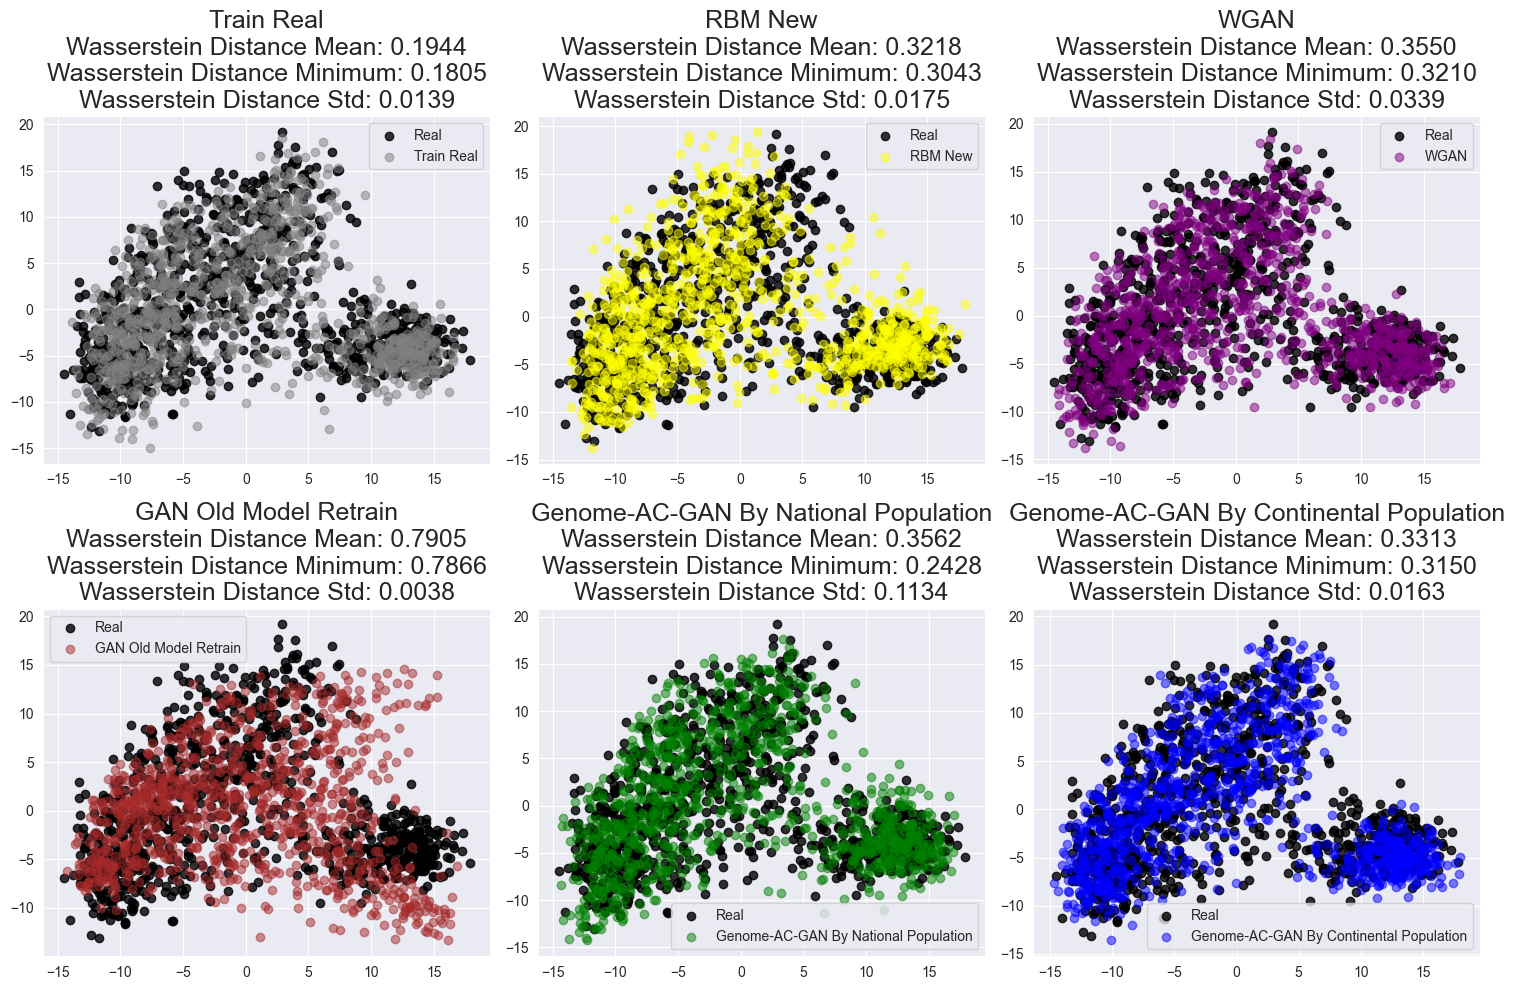

In [8]:
model_to_wasserstein_dists, all_best_sequences = plot_pca_comparison(datasets)

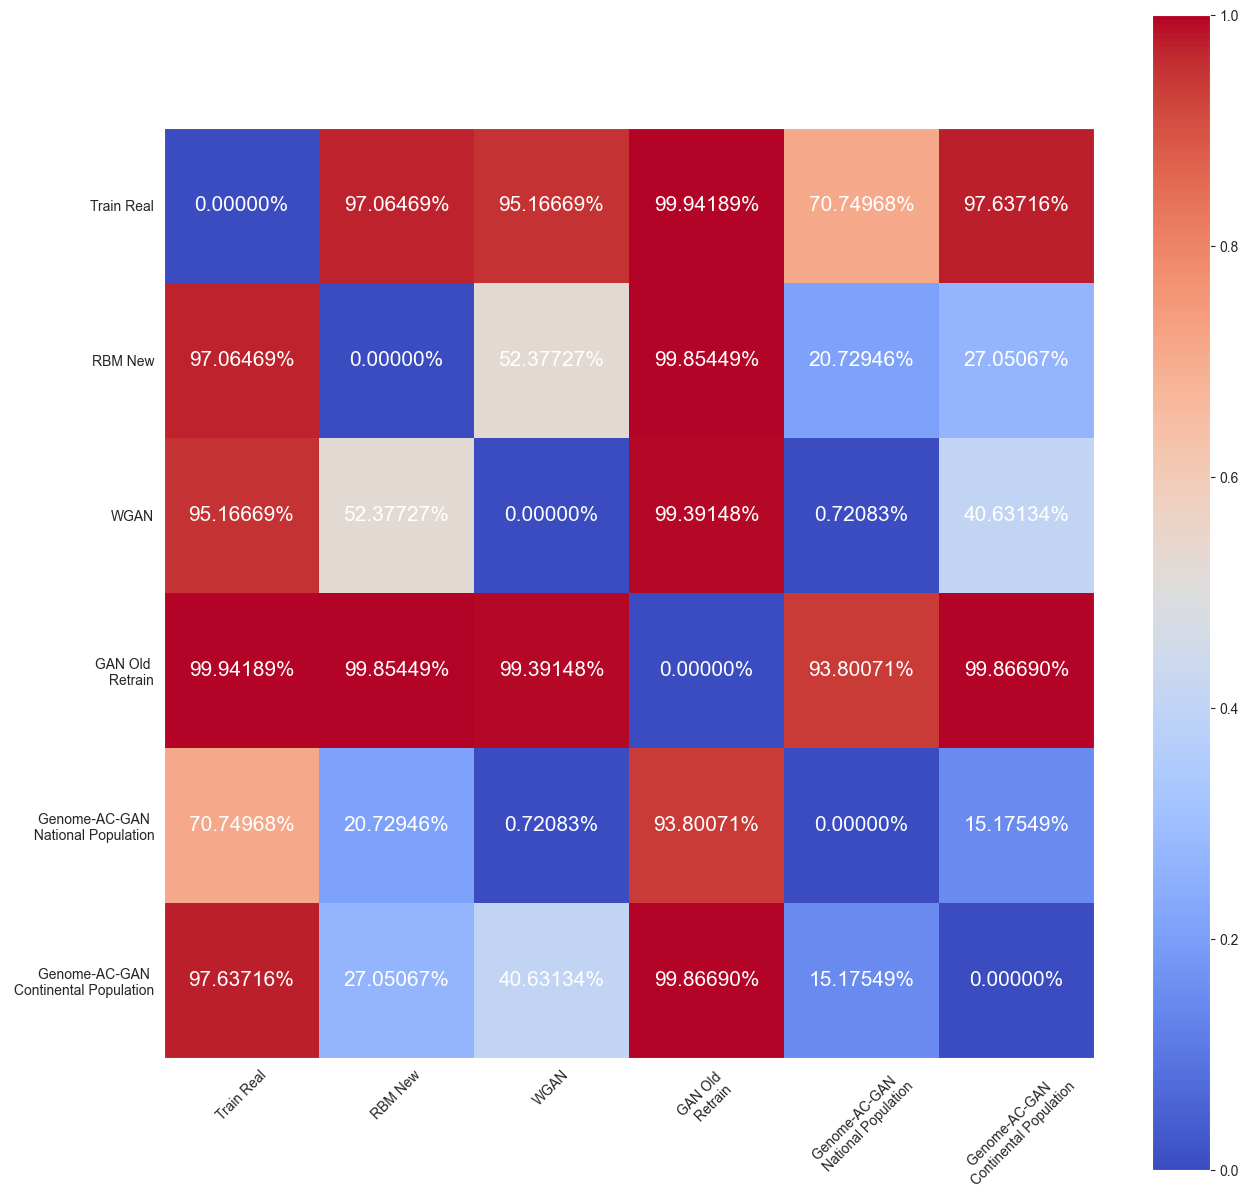

In [9]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

model_names = list(model_to_wasserstein_dists.keys())
model_names = ["\n".join(model_name.split("By")) for model_name in model_names]
model_names = ["\n".join(model_name.split("Model")) for model_name in model_names]
wasserstein_distances = list(model_to_wasserstein_dists.values())

p_values = []
for i in range(len(model_names)):
    for j in range(i + 1, len(model_names)):
        p_values.append(1 - stats.ttest_ind(wasserstein_distances[i], wasserstein_distances[j]).pvalue)

# Reshape the p_values into a 2D matrix
n = len(model_names)
p_values_matrix = np.zeros((n, n))
p_values_matrix[np.triu_indices(n, 1)] = p_values
p_values_matrix += p_values_matrix.T

# Create a plot matrix of the p-values
fig, ax = plt.subplots(figsize=(15, 15))  # Increase the size of the plot
im = ax.imshow(p_values_matrix, cmap='coolwarm', vmin=0, vmax=1)
ax.set_xticks(np.arange(len(model_names)))
ax.set_yticks(np.arange(len(model_names)))
ax.set_xticklabels(model_names, rotation=45)
ax.set_yticklabels(model_names)

# Add numerical values in the matrix
for i in range(n):
    for j in range(n):
        text = ax.text(j, i, f'{p_values_matrix[i, j] * 100:.5f}%', ha='center', va='center', color='w', fontsize=15)

plt.colorbar(im)
ax.grid(False)  # Remove the grid
plt.savefig(os.path.join(output_dir, "P-values wasserstein_distances"))
plt.show()


In [10]:
sum_alleles_by_position, allele_frequency, is_fixed = build_allele_frequency(full_datasets)

In [11]:
def plot_reg(x, y, keys, statname, col, ax=None):
    """
    Plot for x versus y with regression scores and returns correlation coefficient

    Parameters
    ----------
    x : array, scalar
    y : array, scalar
    statname : str
        'Allele frequency' LD' or '3 point correlation' etc.
    col : str, color code
        color

    """

    lims = [np.min(x), np.max(x)]
    r, _ = pearsonr(x, y)
    if sm_loaded:
        reg = sm.OLS(x, y).fit()
    if ax is None:
        ax = plt.subplot(1, 1, 1)
    if len(x) < 100:
        alpha = 1
    else:
        alpha = .6
    ax.plot(x, y, label=f"cor={round(round(r, 3) * 100, 3)}%", c=col, marker='o', lw=0, alpha=alpha)
    ax.plot(lims, lims, ls='--', alpha=1, c='black')
    ax.set_xlabel(f'{statname} in {keys[0]}', fontsize=15)
    ax.set_ylabel(f'{statname} in synthetic data', fontsize=15)
    ax.legend(fontsize=20)
    return r

In [12]:
def plot_allele_frequency(allele_frequency, file_name, maf, highest=False):
    # Plotting Allele frequencies in Generated vs Real
    # below a certain real frequency
    figwi = 14
    l, c = np.ceil(len(allele_frequency) / 4), 3
    plt.figure(figsize=(figwi, figwi * l / c))
    if highest:
        maf = 1 - maf
        keep = (allele_frequency['Real'] >= maf)
    else:
        keep = (allele_frequency['Real'] <= maf)
    for i, (model_name, val) in enumerate(allele_frequency.items()):
        model_name_display = "\n".join(model_name.split("By"))
        model_name_display = "\n".join(model_name_display.split("Model"))
        if model_name != 'Real':
            ax = plt.subplot(int(l), c, i)
            plot_reg(x=allele_frequency['Real'][keep], y=val[keep],
                     keys=['Real', model_name_display], statname="Allele frequency",
                     col=color_palette[model_name], ax=ax)
            plt.title(f'{model_name_display} vs Real', fontsize=20)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, file_name))

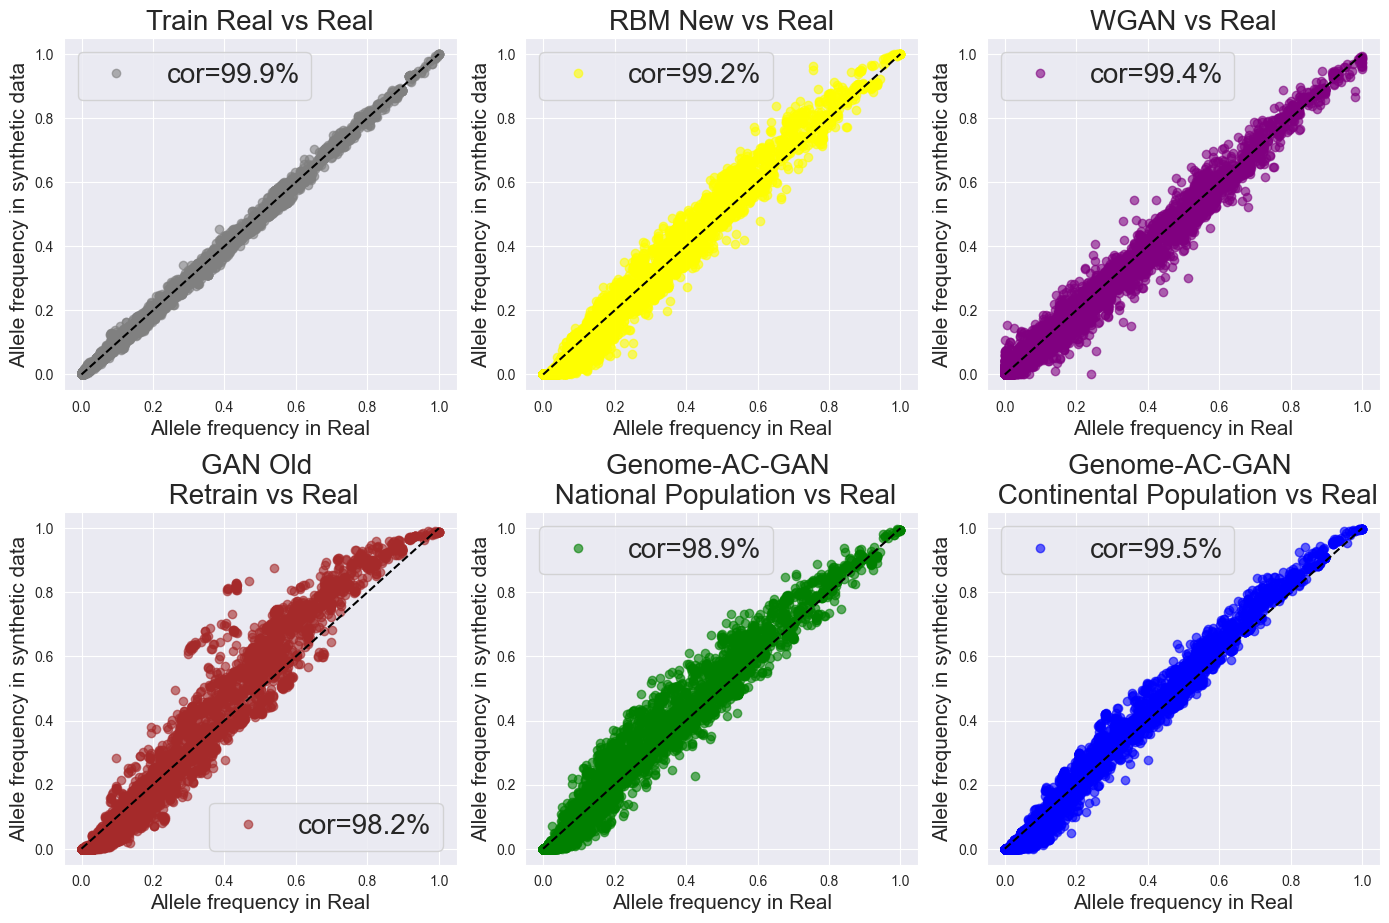

In [13]:
plot_allele_frequency(allele_frequency, 'total_allele_frequency.jpg', 1)

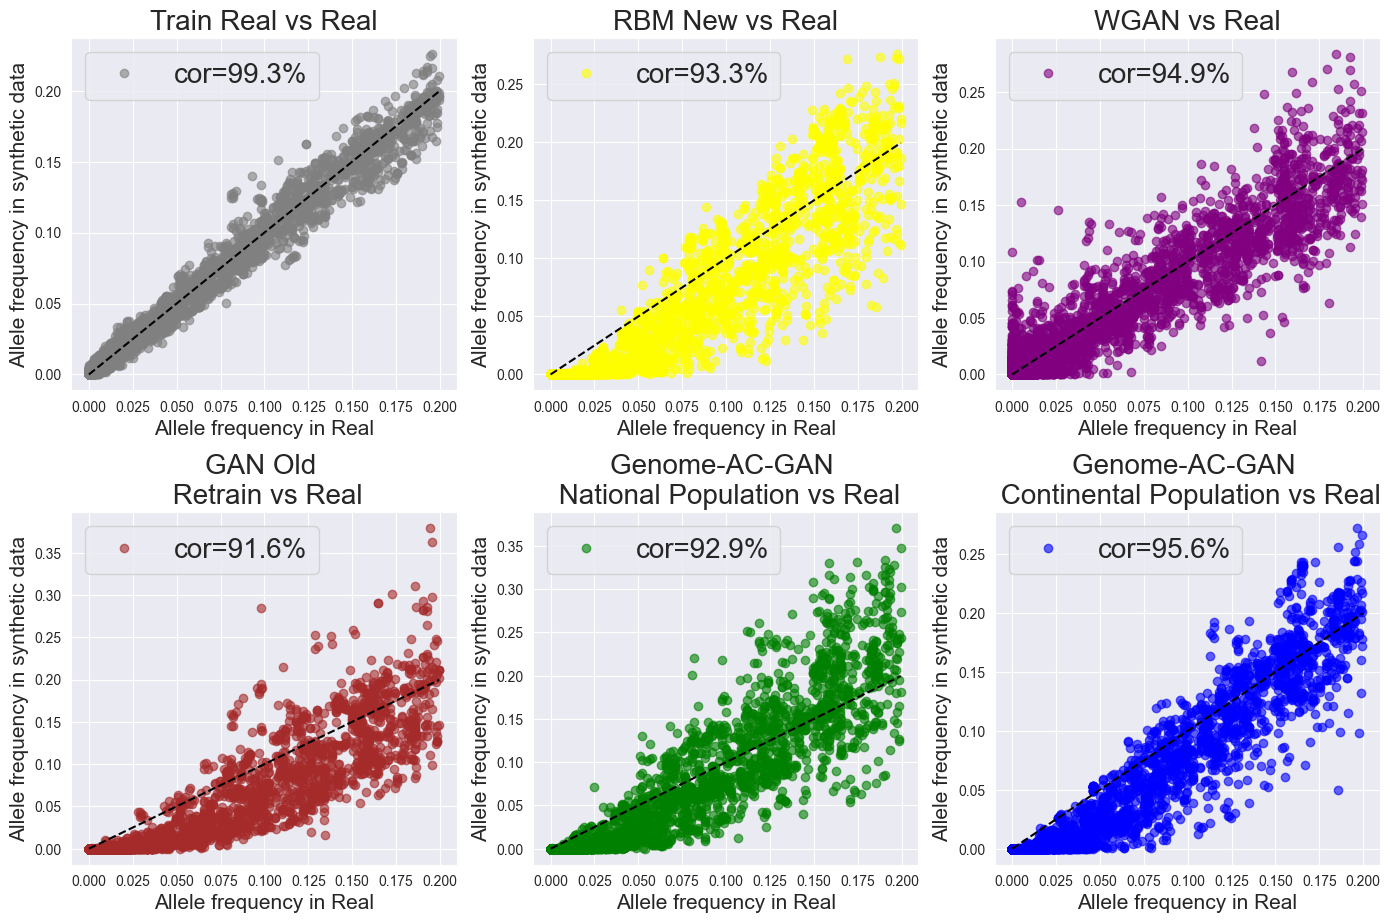

In [14]:
plot_allele_frequency(allele_frequency, 'zoom_lowest_total_allele_frequency.jpg', 0.2)

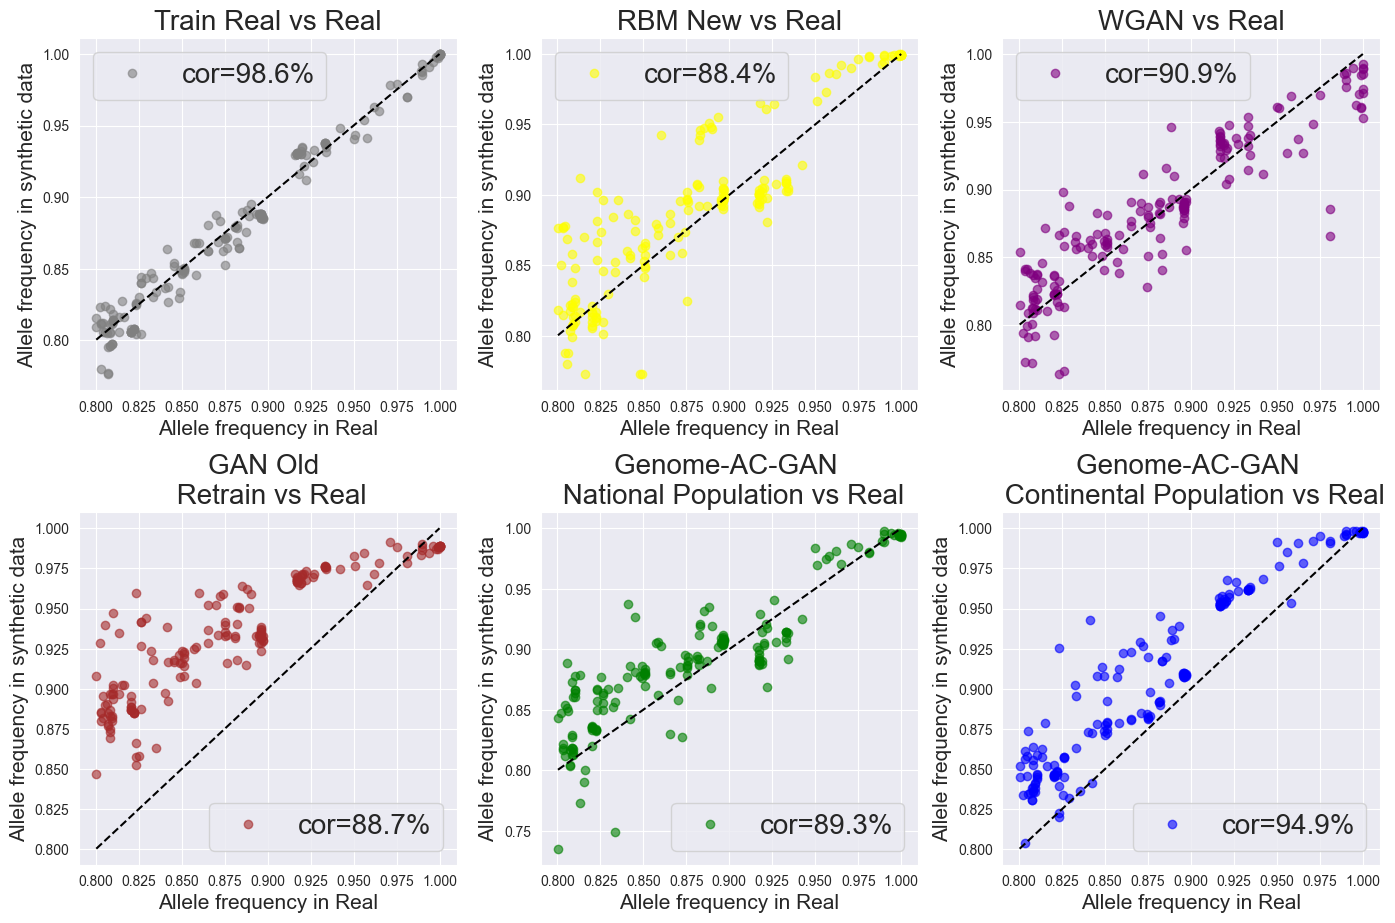

In [15]:
plot_allele_frequency(allele_frequency, 'zoom_highest_total_allele_frequency.jpg', 0.2, highest=True)

In [16]:
def load_analysis_data_for_preview_tests(model_name_to_input_file: dict):
    transformations = {'to_minor_encoding': False, 'min_af': 0, 'max_af': 1}

    datasets, model_keep_all_snps, sample_info = dict(), dict(), dict()
    number_of_samples = 0
    for model_name, data in model_name_to_input_file.items():
        file_path = f"../{data['path']}"
        print(model_name, "loaded from", file_path)
        if file_path.endswith('.csv'):
            model_sequences = pd.read_csv(file_path)
            columns = get_relevant_columns(model_sequences, model_sequences.columns[:2])
            model_sequences = model_sequences[columns]
            columns = [int(i) for i in columns]
            model_sequences.columns = columns
            number_of_samples = len(model_sequences)

        else:
            model_sequences = pd.read_csv(file_path, sep=' ', header=None)
            if 'Genome-AC-GAN' in model_name:
                model_sequences.columns = [column if column == 0 else column + 1 for column in model_sequences.columns]
                model_sequences.insert(0, 1, [f"AG{sample_id}" for sample_id in range(model_sequences.shape[0])])
            if model_sequences.shape[1] == 808:  # special case for a specific file that had an extra empty column
                model_sequences = model_sequences.drop(columns=model_sequences.columns[-1])
            if model_sequences.shape[0] > number_of_samples:
                model_sequences = model_sequences.drop(
                    index=np.sort(
                        np.random.choice(np.arange(model_sequences.shape[0]),
                                         size=model_sequences.shape[0] - number_of_samples,
                                         replace=False))
                )
            if 'Old Model' in model_name :
                model_sequences = model_sequences.drop(columns=list(model_sequences.columns)[-1], axis=1)
                model_sequences.columns = [column + 2 for column in list(model_sequences.columns)]
                model_sequences.insert(loc=0, column=0, value="none")
                model_sequences.insert(loc=1, column=1, value='none')
        # overwrite file first column to set the label name chosen in infiles (eg GAN, etc):
        model_sequences[0] = model_name
        sample_info[model_name] = pd.DataFrame({'label': model_sequences[0], 'ind': model_sequences[1]})
        datasets[model_name] = np.array(model_sequences.loc[:, 2:].astype(int))

        # transformations can be maf filtering, recoding into major=0/minor=1 format
        if transformations is not None:
            datasets[model_name], model_keep_all_snps[model_name] = datatransform(datasets[model_name],
                                                                                  **transformations)
        print(model_name, datasets[model_name].shape)
    extra_sample_info = pd.DataFrame(np.concatenate(list(sample_info.values())), columns=['label', 'id'])
    print("Dictionary of datasets:", len(datasets))
    return extra_sample_info, sample_info, datasets, transformations, model_keep_all_snps, number_of_samples


In [17]:
extra_sample_info, sample_info, datasets, transformations, model_keep_all_snps, number_of_samples = load_analysis_data_for_preview_tests(
    models_to_data)

Real loaded from ../resource/test_0.2_super_pop.csv
Real (1002, 10000)
Train Real loaded from ../resource/train_0.8_super_pop.csv
Train Real (4006, 10000)
RBM New loaded from ../fake_genotypes_sequences/preview_sequences/10K_SNP_GAN_AG_10800Epochs.hapt
RBM New (4006, 10000)
WGAN loaded from ../fake_genotypes_sequences/preview_sequences/10K_WGAN.hapt
WGAN (4006, 10000)
GAN Old Model Retrain loaded from ../experiment_results/old_model_80%_10K/10000_output.hapt
GAN Old Model Retrain (1024, 10000)
Genome-AC-GAN By National Population loaded from ../fake_genotypes_sequences/new_sequences/polyloss_ce_10k_sub_pop/8000_genotypes.hapt
Genome-AC-GAN By National Population (4006, 10000)
Genome-AC-GAN By Continental Population loaded from ../fake_genotypes_sequences/new_sequences/polyloss_ce_10k_pop/9000_genotypes.hapt
Genome-AC-GAN By Continental Population (4006, 10000)
Dictionary of datasets: 7


In [18]:
sum_alleles_by_position, allele_frequency, is_fixed = build_allele_frequency(datasets)


In [19]:
# # Plotting Allele frequencies in Generated vs Real
# # higher than a certain real frequency
# figwi = 12
# l, c = np.ceil(len(allele_frequency) / 4), 3
# plt.figure(figsize=(figwi, figwi * l / c))
# maf = 0.3
# keep = (allele_frequency['Real'] >= 1 - maf)
# for i, (model_name, val) in enumerate(allele_frequency.items()):
#     model_name_display = "\n".join(model_name.split("By"))
#     model_name_display = "\n".join(model_name_display.split("Model"))
#     if model_name != 'Real':
#         ax = plt.subplot(int(l), c, i)
#         plot_reg(x=allele_frequency['Real'][keep], y=val[keep],
#                  keys=['Real', model_name_display], statname="Allele frequency",
#                  col=color_palette[model_name], ax=ax)
#         plt.title(f'{model_name_display} vs Real')
# plt.suptitle(f'Zoom in Allele Frequency highest {maf}% \n')
# plt.tight_layout()
# plt.savefig(os.path.join(output_dir, 'zoom_highest_total_allele_frequency.jpg'))

In [20]:
# def switch_random_positions(array, n):
#     # Flatten the array to 1D
#     flattened_array = array.flatten()
#
#     # Get the indices where the value is 0 or 1
#     zero_indices = np.where(flattened_array == 0)[0]
#     one_indices = np.where(flattened_array == 1)[0]
#
#     # Randomly select n indices to switch from 0 to 1
#     zero_to_one_indices = np.random.choice(zero_indices, size=n, replace=False)
#
#     # Randomly select n indices to switch from 1 to 0
#     one_to_zero_indices = np.random.choice(one_indices, size=n, replace=False)
#
#     # Switch the values at the selected indices
#     flattened_array[zero_to_one_indices] = 1
#     flattened_array[one_to_zero_indices] = 0
#
#     # Reshape the flattened array back to its original shape
#     modified_array = flattened_array.reshape(array.shape)
#
#     return modified_array


In [21]:
# random_positions = datasets['Real'].shape[0] * 100
# print(random_positions)
# datasets['Copy'] = switch_random_positions(datasets['Real'], random_positions)
# real_aug = pd.DataFrame(switch_random_positions(datasets['Real'], random_positions))
# real_aug = real_aug.sample(frac=1, random_state=42)  # Set random_state for reproducibility
# real_aug.reset_index(drop=True, inplace=True)  # Reset the index of the shuffled DataFrame
# real_aug.to_csv("augmented_real_data.csv", index=False)
# real_aug

In [22]:

# plt.figure(figsize=(15, 5 * len(model_name_to_input_file.keys())))
# l, c = len(model_name_to_input_file.keys()) - 1, 2
# plt.figure(figsize=(figwi * c / 4, figwi * l / 4))
# win = 1
# for i, model_name in enumerate(model_name_to_input_file.keys()):
#     if model_name == 'Real': continue
#     plt.subplot(l, c, win)
#     win += 1
#     plt.plot(allele_frequency['Real'][(sum_alleles_by_position[model_name] == 0)], alpha=1, marker='.', lw=0)
#     plt.ylabel("Allele frequency in Real")
#     plt.title("Real frequency of alleles \n absent from {}".format(model_name))
#     plt.subplot(l, c, win)
#     win += 1
#     plt.hist(allele_frequency['Real'][(sum_alleles_by_position[model_name] == 0)], alpha=1)
#     plt.title("Hist real freq of alleles \n absent from {}".format(model_name))
#
# plt.suptitle("Plotting allele frequency characteristics \n\n")
# plt.tight_layout()
# plt.savefig(os.path.join(output_dir, "RealAC_for_0fixed_sites.pdf"))

In [23]:
# random_df = pd.DataFrame(np.random.randint(low=0, high=2, size=(datasets['Real'].shape[0], datasets['Real'].shape[1])))
# random_df.to_csv("random_data.csv", index=False)
# random_df

In [24]:
# def find_different_positions(array1, array2):
#     # Find positions where array1 and array2 have different values
#     different_positions = np.where(array1 != array2)
#
#     return different_positions
#
#
# different_positions = find_different_positions(real_aug.to_numpy(), datasets['Real'])
# print(len(different_positions[1]) / (datasets['Real'].shape[0] * datasets['Real'].shape[1]))

In [25]:
# from scipy.stats import entropy
# import numpy as np
# import pandas as pd
# from scipy import stats
# from sklearn.metrics import mutual_info_score
#
#
# def statistical_analysis_test(real_df, synthetic_df):
#     # Perform statistical analysis on the datasets
#     # Calculate summary statistics and compare distributions
#
#     # Calculate mean and variance for real and synthetic datasets
#     real_mean = real_df.mean()
#     synthetic_mean = synthetic_df.mean()
#
#     # Perform t-test between real and synthetic means
#     t_stat, p_value = stats.ttest_ind(real_mean, synthetic_mean)
#
#     # Perform Kolmogorov-Smirnov test between real and synthetic distributions
#     ks_stat, ks_p_value = stats.ks_2samp(real_df.values.flatten(), synthetic_df.values.flatten())
#
#     # Return the results
#     return t_stat, p_value, ks_stat, ks_p_value
#
#
# def information_theory_test(real_df, synthetic_df):
#     # Perform information theory test on the datasets
#     # Calculate entropy, mutual information, or Kullback-Leibler divergence
#
#     # Calculate entropy for real and synthetic datasets
#     real_entropy = calculate_entropy(real_df)
#     synthetic_entropy = calculate_entropy(synthetic_df)
#
#     # Calculate mutual information between real and synthetic datasets
#     mutual_info = mutual_info_score(real_df.values.flatten(), synthetic_df.values.flatten())
#
#     # Calculate Kullback-Leibler divergence between real and synthetic distributions
#     kl_divergence = calculate_kl_divergence(real_df, synthetic_df)
#
#     # Return the results
#     return real_entropy, synthetic_entropy, mutual_info, kl_divergence
#
#
# # Helper functions
#
# def calculate_entropy(data):
#     # Calculate entropy for a given dataset
#     n_samples, n_features = data.shape
#     entropy = np.zeros(n_features)
#
#     for i in range(n_features):
#         feature_counts = data.iloc[:, i].value_counts()
#         probabilities = feature_counts / n_samples
#         entropy[i] = stats.entropy(probabilities)
#
#     return entropy
#
#
# def calculate_kl_divergence(p, q, epsilon=1e-9):
#     # Calculate Kullback-Leibler divergence between two datasets
#     kl_divergence = np.zeros(p.shape[1])
#
#     for i in range(p.shape[1]):
#         p_smoothed = p.iloc[:, i] + epsilon
#         q_smoothed = q.iloc[:, i] + epsilon
#         kl_divergence[i] = entropy(p_smoothed, q_smoothed)
#
#     return kl_divergence


In [26]:
# real_entropy_by_pop, synthetic_entropy_by_pop, mutual_info_by_pop, kl_divergence_by_pop = information_theory_test(
#     pd.DataFrame(datasets['Real']),
#     pd.DataFrame(datasets[
#                      'Genome-AC-GAN super pop']))
# t_stat_by_pop, p_value_by_pop, ks_stat_by_pop, ks_p_value_by_pop = statistical_analysis_test(
#     pd.DataFrame(datasets['Real']),
#     pd.DataFrame(datasets['Genome-AC-GAN super pop']))
#
# real_entropy_by_sub_pop, synthetic_entropy_by_sub_pop, mutual_info_by_sub_pop, kl_divergence_by_sub_pop = information_theory_test(
#     pd.DataFrame(datasets['Real']),
#     pd.DataFrame(datasets[
#                      'Genome-AC-GAN super pop']))
# t_stat_by_sub_pop, p_value_by_sub_pop, ks_stat_by_sub_pop, ks_p_value_by_sub_pop = statistical_analysis_test(
#     pd.DataFrame(datasets['Real']),
#     pd.DataFrame(datasets['Genome-AC-GAN sub pop']))
#
# real_entropy_wgan, synthetic_entropy_wgan, mutual_info_wgan, kl_divergence_wgan = information_theory_test(
#     pd.DataFrame(datasets['Real']), pd.DataFrame(datasets['WGAN']))
# t_stat_wgan, p_value_wgan, ks_stat_wgan, ks_p_value_wgan = statistical_analysis_test(pd.DataFrame(datasets['Real']),
#                                                                                      pd.DataFrame(datasets['WGAN']))
#
# real_entropy_rbm, synthetic_entropy_rbm, mutual_info_rbm, kl_divergence_rbm = information_theory_test(
#     pd.DataFrame(datasets['Real']), pd.DataFrame(datasets['RBM_new']))
# t_stat_rbm, p_value_rbm, ks_stat_rbm, ks_p_value_rbm = statistical_analysis_test(pd.DataFrame(datasets['Real']),
#                                                                                  pd.DataFrame(datasets['RBM_new']))
#
# real_entropy_real, synthetic_entropy_real, mutual_info_real, kl_divergence_real = information_theory_test(
#     pd.DataFrame(datasets['Real']), pd.DataFrame(datasets['Real']))
# t_stat_real, p_value_real, ks_stat_real, ks_p_value_real = statistical_analysis_test(pd.DataFrame(datasets['Real']),
#                                                                                      pd.DataFrame(datasets['Real']))
#
# real_entropy_random, synthetic_entropy_random, mutual_info_random, kl_divergence_random = information_theory_test(
#     pd.DataFrame(datasets['Real']), random_df)
# t_stat_random, p_value_random, ks_stat_random, ks_p_value_random = statistical_analysis_test(
#     pd.DataFrame(datasets['Real']), random_df)
#
# _, _, mutual_info_aug, kl_divergence_aug = information_theory_test(pd.DataFrame(datasets['Real']), real_aug)
# t_stat_aug, p_value_aug, ks_stat_aug, ks_p_value_aug = statistical_analysis_test(pd.DataFrame(datasets['Real']),
#                                                                                  real_aug)

In [27]:
# privacy_results = pd.DataFrame(
#     {"test_type": ["real vs real", "real vs real_switched", "real vs random", "real vs wgan", "real vs rbm",
#                    "real vs new super pop", "real vs new sub pop"],
#      "mutual_info": [round(mutual_info_real, 6), round(mutual_info_aug, 6), round(mutual_info_random, 6),
#                      round(mutual_info_wgan, 6), round(mutual_info_rbm, 6), round(mutual_info_by_pop, 6),
#                      round(mutual_info_by_sub_pop, 7)],
#      "t_stat": [round(t_stat_real, 7), round(t_stat_aug, 7), round(t_stat_random, 7), round(t_stat_wgan, 7),
#                 round(t_stat_rbm, 7), round(t_stat_by_pop, 7), round(t_stat_by_sub_pop, 7)],
#      "p_value": [round(p_value_real, 7), round(p_value_aug, 7), round(p_value_random, 7), round(p_value_wgan, 7),
#                  round(p_value_rbm, 7), round(p_value_by_pop, 7), round(p_value_by_sub_pop, 7)],
#      "ks_stat": [round(ks_stat_real, 7), round(ks_stat_aug, 7), round(ks_stat_random, 7), round(ks_stat_wgan, 7),
#                  round(ks_stat_rbm, 7), round(ks_stat_by_pop, 7), round(ks_stat_by_sub_pop, 7)]})
# privacy_results

In [28]:
# def re_identification_risk(df_real, df_synthetic):
#     # Calculate the re-identification risk based on distance metrics
#     euclidean_dist = distance.euclidean(df_real.values.flatten(), df_synthetic.values.flatten())
#     cosine_dist = distance.cosine(df_real.values.flatten(), df_synthetic.values.flatten())
#     re_identification_risk = euclidean_dist + cosine_dist
#     return re_identification_risk
#
#
# print(
#     re_identification_risk(pd.DataFrame(datasets['Real']), pd.DataFrame(datasets['Genome-AC-GAN sub pop'])),
#     re_identification_risk(pd.DataFrame(datasets['Real']), pd.DataFrame(datasets['RBM_new'])),
#     re_identification_risk(pd.DataFrame(datasets['Real']), random_df))

In [29]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
#
#
# def generalization_accuracy(real_df, synthetic_df, target_column):
#     X = pd.concat([real_df, synthetic_df])
#     y = pd.concat([pd.Series([1] * len(real_df)), pd.Series([0] * len(synthetic_df))])
#
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#     model = LogisticRegression()
#     model.fit(X_train, y_train)
#
#     return model.score(X_test, y_test)
#
#
# generalization_accuracy(pd.DataFrame(datasets['Real']),
#                         pd.DataFrame(datasets['Genome-AC-GAN super pop']), target_column)


In [30]:
# def calculate_hamming_distance(array1, array2):
#     return np.sum(array1 != array2, axis=1)
#
#
# def add_laplace_noise(values, epsilon):
#     sensitivity = 1.0  # Sensitivity of the Hamming distance is 1
#     scale = sensitivity / epsilon
#     noise = np.random.laplace(loc=0.0, scale=scale, size=len(values))
#     return values + noise

In [31]:
# print(pd.DataFrame(datasets['Real']).shape, pd.DataFrame(datasets['Genome-AC-GAN super pop']).shape)

In [32]:
# hamming_distances = calculate_hamming_distance(datasets['Real'], datasets['Genome-AC-GAN super pop'])
# epsilon = 2
# noisy_hamming_distances = add_laplace_noise(hamming_distances, epsilon)
# print(noisy_hamming_distances)

In [33]:
# # Plotting Allele frequencies in Generated vs Real
# l, c = np.ceil(len(allele_frequency) / 3), 3
# plt.figure(figsize=(figwi, figwi * l / c))
# for i, (model_name, val) in enumerate(allele_frequency.items()):
#     ax = plt.subplot(int(l), 3, i + 1)
#     plotreg(x=allele_frequency['Real'], y=val,
#             keys=['Real', model_name], statname="Allele frequency",
#             col=color_palette[model_name], ax=ax)
#     plt.title(f'Allele Frequencies {model_name} vs Real')
# plt.suptitle(f'Allele Frequencies vs Real \n\n')
# plt.tight_layout()
# plt.savefig(os.path.join(output_dir, 'AC_generated_vs_Real.pdf'))

In [34]:

# score_list = []
# number_of_components = 6  # change to compute more PCs
#
# method_name = "model_results_on_real_pca"
# print(f'Computing {method_name} ...')
# pca = PCA(n_components=number_of_components)
# # real_pca = pca.fit_transform(datasets['Real'])
# pca.fit_transform(  #datasets['Real']
#     np.concatenate(list(datasets.values()))
# )
#
# pcs = pca.transform(np.concatenate(list(datasets.values())))
#
# pcdf = pd.DataFrame(pcs, columns=["PC{}".format(x + 1) for x in np.arange(pcs.shape[1])])
# pcdf["label"] = extra_sample_info.label.astype('category')
# plotPCAallfigs(pcdf, method_name, orderedCat=models_to_data.keys(), output_dir=output_dir,
#                colpal=color_palette, levels=10)
# plt.suptitle("PCA Comparison")
# plt.savefig(os.path.join(output_dir, "PCA.jpg"))
# plt.show()

* Computing and plotting LD...
Real
Train Real
RBM New
WGAN
GAN Old Model Retrain
Genome-AC-GAN By National Population
Genome-AC-GAN By Continental Population


/Users/shakedahronoviz/Genome-AC-GAN/utils/util.py:185: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kept_snp != 'all':


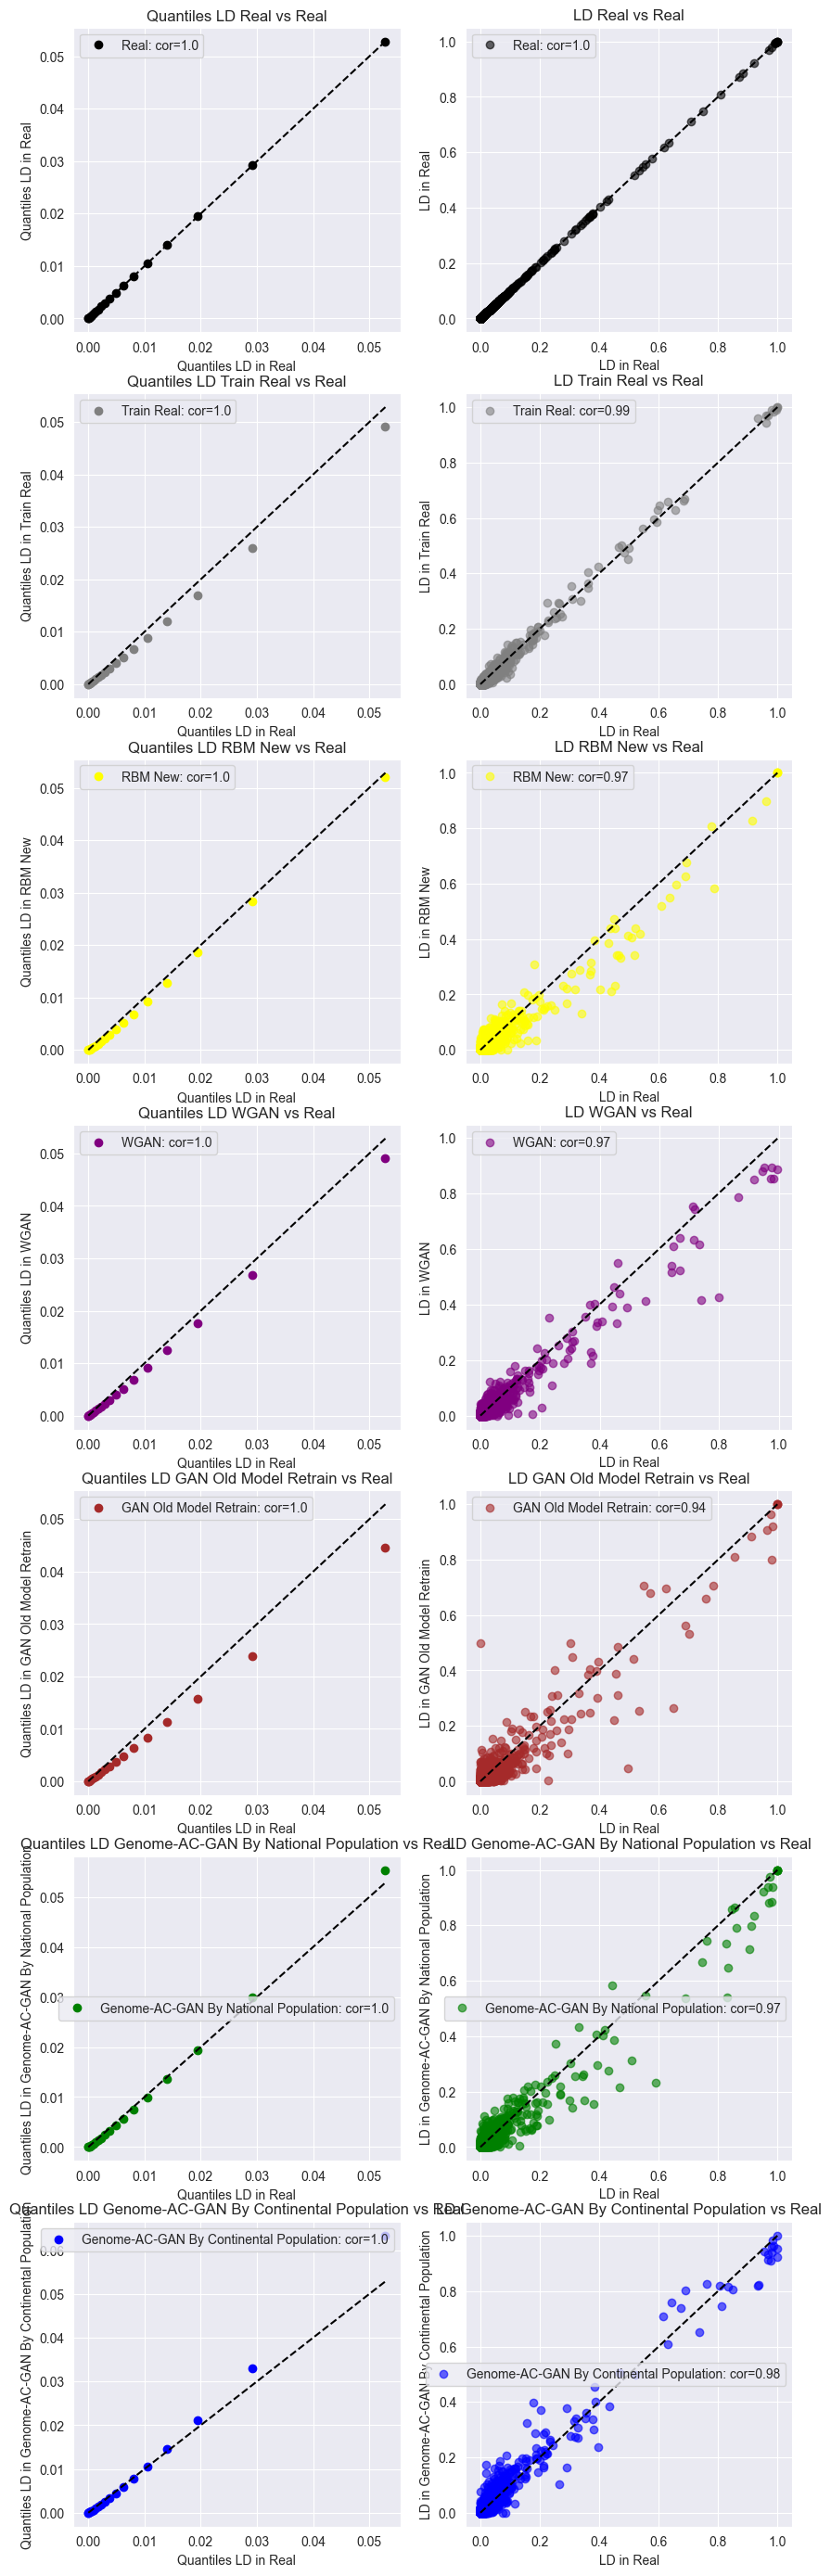

In [35]:
print("* Computing and plotting LD...")
#### Compute correlation between all pairs of SNPs for each generated/real dataset

model_names = models_to_data.keys()
hcor_snp = dict()
for i, model_name in enumerate(model_names):
    print(model_name)
    with np.errstate(divide='ignore', invalid='ignore'):
        # Catch warnings due to fixed sites in dataset (the correlation value will be np.nan for pairs involving these sites)
        hcor_snp[model_name] = np.corrcoef(datasets[model_name], rowvar=False) ** 2  # r2

_, region_len, snps_on_same_chrom = get_dist(f"../{REAL_POSITION_FILE_NAME}", region_len_only=True,
                                             kept_preprocessing=model_keep_all_snps['Real'])

nbins = 100
logscale = True
bins = nbins
binsPerDist = nbins
if logscale: binsPerDist = np.logspace(np.log(1), np.log(region_len), nbins)

# Compute LD binned by distance
# Take only sites that are SNPs in all datasets (intersect)
# (eg intersection of SNPs in Real, SNPs in GAN, SNPs in RBM etc)
# -> Makes sense only if there is a correspondence between sites

binnedLD = dict()
binnedPerDistLD = dict()
kept_snp = ~is_fixed
n_kept_snp = np.sum(kept_snp)
realdist = get_dist(f"../{REAL_POSITION_FILE_NAME}", kept_preprocessing=model_keep_all_snps['Real'],
                    kept_snp=kept_snp)[0]
mat = hcor_snp['Real']
# filter and flatten
flatreal = (mat[np.ix_(kept_snp, kept_snp)])[np.triu_indices(n_kept_snp)]
isnanReal = np.isnan(flatreal)
i = 1
plt.figure(figsize=(10, len(hcor_snp) * 5))

for model_name, mat in hcor_snp.items():
    flathcor = (mat[np.ix_(kept_snp, kept_snp)])[np.triu_indices(n_kept_snp)]
    isnan = np.isnan(flathcor)
    curr_dist = realdist

    # For each dataset LD pairs are stratified by SNP distance and cut into 'nbins' bins
    # bin per SNP distance
    ld = binned_statistic(curr_dist[~isnan], flathcor[~isnan], statistic='mean', bins=binsPerDist)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)  # so that empty bins do not raise a warning
        binnedPerDistLD[model_name] = pd.DataFrame({'bin_edges': ld.bin_edges[:-1],
                                                    'LD': ld.statistic,
                                                    # 'sd': binned_statistic(curr_dist[~isnan], flathcor[~isnan], statistic = 'std', bins=binsPerDist).statistic,
                                                    'sem': binned_statistic(curr_dist[~isnan], flathcor[~isnan],
                                                                            statistic=sem,
                                                                            bins=binsPerDist).statistic,
                                                    'model_name': model_name, 'logscale': logscale})

    # For each dataset LD pairs are stratified by LD values in Real and cut into 'nbins' bins
    # binnedLD contains the average, std of LD values in each bin
    isnan = np.isnan(flathcor) | np.isnan(flatreal)
    ld = binned_statistic(flatreal[~isnan], flathcor[~isnan], statistic='mean', bins=bins)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)  # so that empty bins do not raise a warning
        binnedLD[model_name] = pd.DataFrame({'bin_edges': ld.bin_edges[:-1],
                                             'LD': ld.statistic,
                                             'sd': binned_statistic(flatreal[~isnan], flathcor[~isnan],
                                                                    statistic='std',
                                                                    bins=bins).statistic,
                                             'sem': binned_statistic(flatreal[~isnan], flathcor[~isnan],
                                                                     statistic=sem,
                                                                     bins=bins).statistic,
                                             'model_name': model_name, 'logscale': logscale})

    # Plotting quantiles ?
    plotregquant(x=flatreal, y=flathcor,
                 keys=['Real', model_name], statname='LD', col=color_palette[model_name],
                 step=0.05,
                 ax=plt.subplot(len(hcor_snp), 2, i))
    i += 1
    plt.title(f'Quantiles LD {model_name} vs Real')

    # removing nan values and subsampling before doing the regression to have a reasonnable number of points
    isnanInter = isnanReal | isnan
    keepforplotreg = random.sample(list(np.where(~isnanInter)[0]), number_of_samples)
    plotreg(x=flatreal[keepforplotreg], y=flathcor[keepforplotreg],
            keys=['Real', model_name], statname='LD', col=color_palette[model_name],
            ax=plt.subplot(len(hcor_snp), 2, i))
    i += 1
    plt.title(f'LD {model_name} vs Real')
plt.savefig(os.path.join(output_dir, "LD_generated_vs_real_intersectSNP.pdf"))

In [36]:
import pandas as pd
from scipy.stats import binned_statistic, sem
import warnings


def compute_and_plot_ld(real_data, synthetic_data, output_dir):
    model_names = synthetic_data.keys()
    hcor_snp = dict()

    for model_name in model_names:
        with np.errstate(divide='ignore', invalid='ignore'):
            hcor_snp[model_name] = np.corrcoef(real_data[model_name], rowvar=False) ** 2  # r2

    _, region_len, snps_on_same_chrom = get_dist(f"../{REAL_POSITION_FILE_NAME}", region_len_only=True,
                                                 kept_preprocessing=real_data)

    nbins = 100
    logscale = True
    bins = nbins
    binsPerDist = nbins
    if logscale:
        binsPerDist = np.logspace(np.log(1), np.log(region_len), nbins)

    binnedLD = dict()
    binnedPerDistLD = dict()
    realdist = get_dist(f"../{REAL_POSITION_FILE_NAME}", kept_preprocessing=real_data,
                        kept_snp='all')[0]
    mat = hcor_snp['Real']
    flatreal = (mat[np.ix_(kept_snp, kept_snp)])[np.triu_indices(n_kept_snp)]
    isnanReal = np.isnan(flatreal)
    i = 1

    plt.figure(figsize=(10, len(hcor_snp) * 5))

    for model_name, mat in hcor_snp.items():
        flathcor = (mat[np.ix_(kept_snp, kept_snp)])[np.triu_indices(n_kept_snp)]
        isnan = np.isnan(flathcor)
        curr_dist = realdist

        ld = binned_statistic(curr_dist[~isnan], flathcor[~isnan], statistic='mean', bins=binsPerDist)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            binnedPerDistLD[model_name] = pd.DataFrame({'bin_edges': ld.bin_edges[:-1],
                                                        'LD': ld.statistic,
                                                        'sem': binned_statistic(curr_dist[~isnan], flathcor[~isnan],
                                                                                statistic=sem,
                                                                                bins=binsPerDist).statistic,
                                                        'model_name': model_name, 'logscale': logscale})

        isnan = np.isnan(flathcor) | np.isnan(flatreal)
        ld = binned_statistic(flatreal[~isnan], flathcor[~isnan], statistic='mean', bins=bins)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            binnedLD[model_name] = pd.DataFrame({'bin_edges': ld.bin_edges[:-1],
                                                 'LD': ld.statistic,
                                                 'sd': binned_statistic(flatreal[~isnan], flathcor[~isnan],
                                                                        statistic='std',
                                                                        bins=bins).statistic,
                                                 'sem': binned_statistic(flatreal[~isnan], flathcor[~isnan],
                                                                         statistic=sem,
                                                                         bins=bins).statistic,
                                                 'model_name': model_name, 'logscale': logscale})

        # Plotting quantiles ?
        plotregquant(x=flatreal, y=flathcor,
                     keys=['Real', model_name], statname='LD', col=color_palette[model_name],
                     step=0.05,
                     ax=plt.subplot(len(hcor_snp), 2, i))
        i += 1
        plt.title(f'Quantiles LD {model_name} vs Real')

        # removing nan values and subsampling before doing the regression to have a reasonnable number of points
        isnanInter = isnanReal | isnan
        keepforplotreg = random.sample(list(np.where(~isnanInter)[0]), number_of_samples)
        plotreg(x=flatreal[keepforplotreg], y=flathcor[keepforplotreg],
                keys=['Real', model_name], statname='LD', col=color_palette[model_name],
                ax=plt.subplot(len(hcor_snp), 2, i))
        i += 1
        plt.title(f'LD {model_name} vs Real')
    plt.savefig(os.path.join(output_dir, "LD_generated_vs_real_intersectSNP.pdf"))


In [37]:


# def plot_ld_compression(array1, array2):
#     # Check if the arrays have the same number of columns
#     if array1.shape[1] != array2.shape[1]:
#         raise ValueError("Arrays must have the same number of columns.")
#
#     # Resize arrays to have the same number of rows
#     min_rows = min(array1.shape[0], array2.shape[0])
#     array1 = array1[:min_rows, :]
#     array2 = array2[:min_rows, :]
#
#     # Create a compressed array
#     compressed_array = np.zeros(array1.shape)
#
#     # Iterate through each element in the arrays
#     for i in range(array1.shape[0]):
#         for j in range(array1.shape[1]):
#             # Check if the genotypes are the same
#             if array1[i, j] == array2[i, j]:
#                 compressed_array[i, j] = array1[i, j]
#
#     # Calculate the difference between the original and compressed arrays
#     diff_array = array1 - compressed_array
#
#     # Set up the plot layout
#     fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
#
#     # Plot the original Array 1
#     img1 = axes[0].imshow(array1, cmap='coolwarm', aspect='auto', vmin=0, vmax=1)
#     axes[0].set_title('Original Array')
#     axes[0].axis('off')
#
#     # Plot the compressed array
#     img2 = axes[1].imshow(compressed_array, cmap='coolwarm', aspect='auto', vmin=0, vmax=1)
#     axes[1].set_title('Compressed Array')
#     axes[1].axis('off')
#
#     # Plot the difference between the original and compressed arrays
#     img3 = axes[2].imshow(diff_array, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
#     axes[2].set_title('Difference')
#     axes[2].axis('off')
#
#     # Add a colorbar for the difference plot
#     cbar = fig.colorbar(img3, ax=axes[2])
#     cbar.set_label('Difference')
#
#     # Adjust the spacing between subplots
#     plt.tight_layout()
#
#     # Display the plot
#     plt.show()


In [38]:
# import numpy as np
# import matplotlib.pyplot as plt
#
# def plot_ld_generated_vs_real_intersect_snp(real_data, synthetic_data):
#     # Calculate the intersection of SNP values
#     intersect_snp = np.sum(real_data == synthetic_data, axis=1)
#
#     # Calculate the LD between real and synthetic datasets
#     ld = np.corrcoef(real_data.T, synthetic_data.T)
#
#     # Plotting
#     plt.figure(figsize=(10, 6))
#     plt.scatter(range(len(intersect_snp)), intersect_snp, c=ld[1:, 0], cmap='cool', alpha=0.7)
#     plt.xlabel('SNP Index')
#     plt.ylabel('Intersection of SNP Values')
#     plt.title('LD: Generated vs Real - Intersect SNP')
#     cbar = plt.colorbar()
#     cbar.set_label('LD Correlation')
#     plt.savefig('LD_generated_vs_real_intersectSNP.jpg')
#     plt.show()


In [39]:
# plot_ld_generated_vs_real_intersect_snp(full_datasets['Real'], full_datasets['WGAN'])

In [40]:
# plot_ld_compression(full_datasets['Real'], full_datasets['Genome-AC-GAN By National Population'])

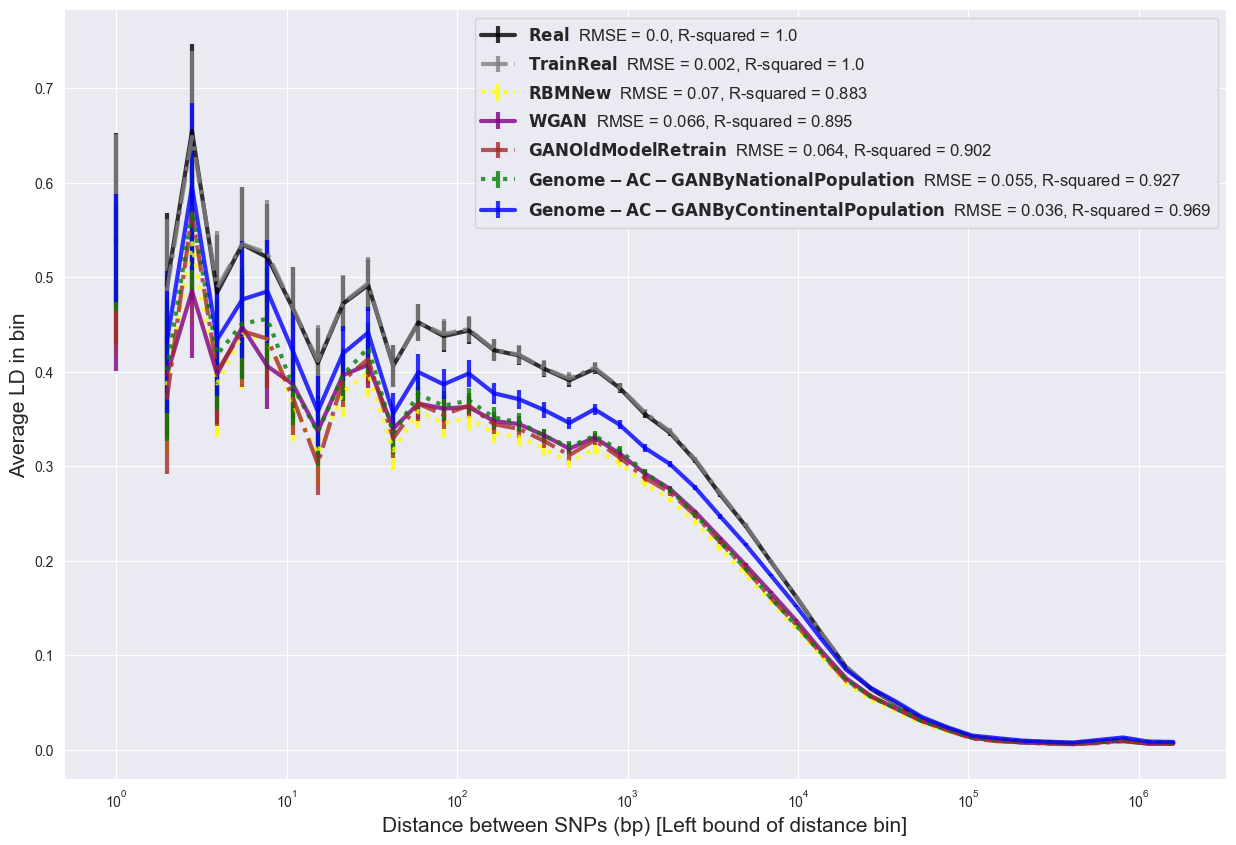

In [41]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
line_styles = ['solid', 'dashdot', 'dotted']
scores = []
real_bld = binnedPerDistLD['Real'].LD.values[~np.isnan(binnedPerDistLD['Real'].LD.values)]
# Calculate the absolute difference from the "Real" line
for index, (model_name, bld) in enumerate(binnedPerDistLD.items()):
    style_index = index % len(line_styles)
    line_style = line_styles[style_index]
    r2 = round(r2_score(real_bld, bld.LD.values[~np.isnan(bld.LD.values)]), 3)
    rmse = round(np.sqrt(mean_squared_error(real_bld, bld.LD.values[~np.isnan(bld.LD.values)])), 3)
    plt.errorbar(
        bld.bin_edges.values, bld.LD.values, bld['sem'].values,
        label=r"$\mathbf{" + model_name + "}$  RMSE = " + str(rmse) + ", R-squared = " + str(r2),
        alpha=0.8, linewidth=3, linestyle=line_style
    )

# plt.title("Binned LD +/- 1 sem")
if logscale:
    plt.xscale('log')
# plt.yscale('log')
plt.xlabel("Distance between SNPs (bp) [Left bound of distance bin]", fontsize=15)
plt.ylabel("Average LD in bin", fontsize=15)
plt.legend(fontsize='large', loc="upper right")

plt.savefig(os.path.join(output_dir, "correlation_vs_dist_intersectSNP.jpg"))


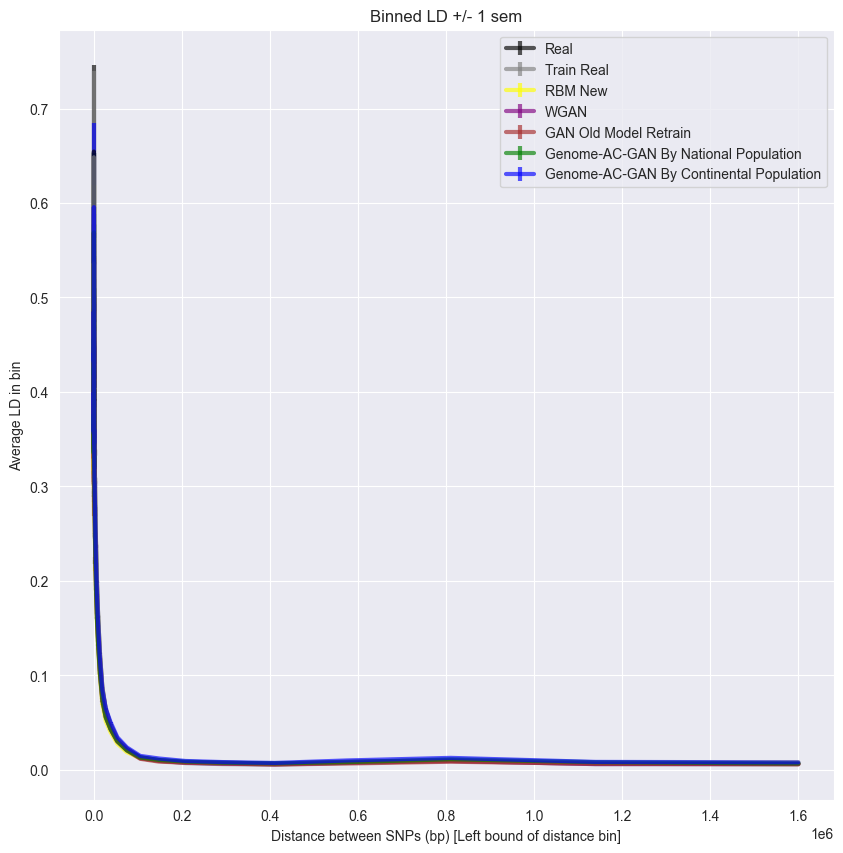

In [42]:
import matplotlib.pyplot as plt

# Create a figure and axes object
fig, axes = plt.subplots(figsize=(10, 10))

# Plot the data for each model
for model_name, bld in binnedPerDistLD.items():
    plt.errorbar(bld.bin_edges.values, bld.LD.values, bld['sem'].values, label=model_name, alpha=.65,
                 linewidth=3, color=color_palette[model_name])

# Add a title to the plot
plt.title("Binned LD +/- 1 sem")

# Set the x-axis label
plt.xlabel("Distance between SNPs (bp) [Left bound of distance bin]")

# Set the y-axis label
plt.ylabel("Average LD in bin")

# Add a legend to the plot
plt.legend()

# Save the plot
plt.savefig(os.path.join(output_dir, "correlation_vs_dist_intersectSNP.pdf"))

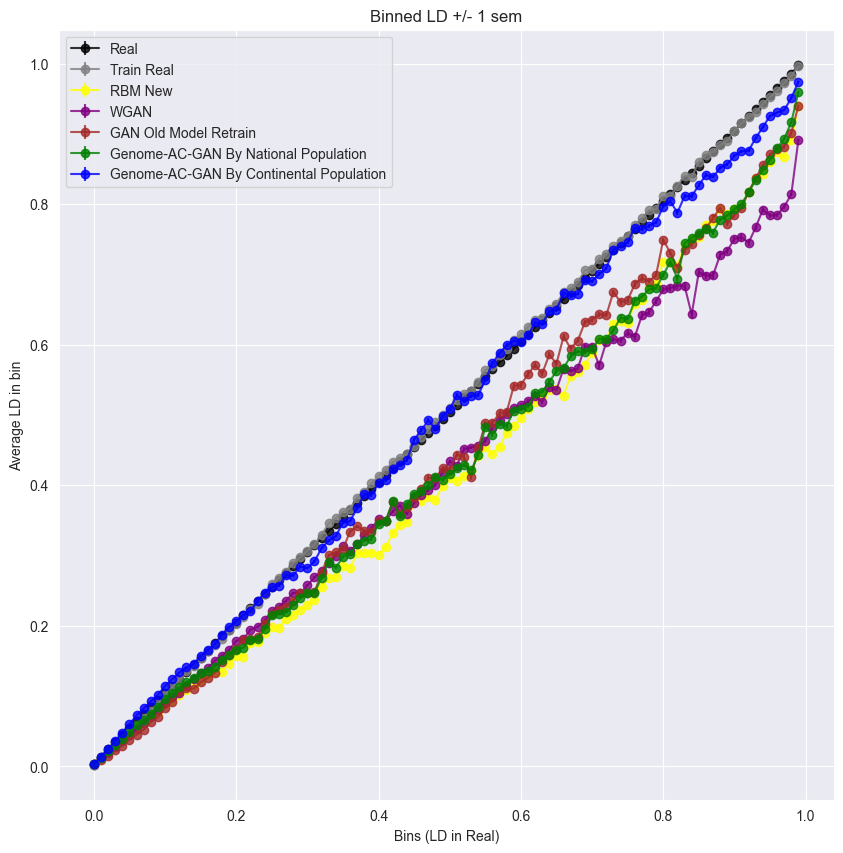

In [43]:
import matplotlib.pyplot as plt

# For each dataset LD pairs were stratified by LD values in Real, cut into nbins bins
# binnedLD contains the average LD in each bin
# Plot generated average LD as a function of the real average LD in the bins
plt.figure(figsize=(10, 10))
for model_name, bld in binnedLD.items():
    plt.errorbar(bld.bin_edges.values, bld.LD.values, bld['sem'].values, label=model_name, alpha=0.8, marker='o')
plt.title("Binned LD +/- 1 sem")
plt.xlabel("Bins (LD in Real)")
plt.ylabel("Average LD in bin")
plt.legend()
plt.savefig(os.path.join(output_dir, 'LD decay.jpg'))



In [44]:
# # Set edges of the region for which to plot LD block matrix (l=0, f='end') for full region
# # not used as for now apart from the filename
# l_bound = None
# r_bound = None
# snpcode = "fullSNP"
# mirror, diff = False, False
# outfilename = f"LD_HEATMAP_{snpcode}_bounds={l_bound}-{r_bound}_mirror={mirror}_diff={diff}.pdf"
# fig = plt.figure(figsize=(10 * len(hcor_snp), 10))
# plotLDblock(hcor_snp,
#             left=l_bound, right=r_bound,  # None, None -> takes all SNPs
#             mirror=mirror, diff=diff,
#             is_fixed=is_fixed, is_fixed_dic=is_fixed_dic,
#             suptitle_kws={'t': outfilename}
#             )
# plt.title(outfilename)
# plt.savefig(os.path.join(output_dir, outfilename))
# plt.show()
#
# print(
#     '****************************************************************\n*** Computation and plotting LD DONE. Figures saved in {} ***\n****************************************************************'.format(
#         output_dir))

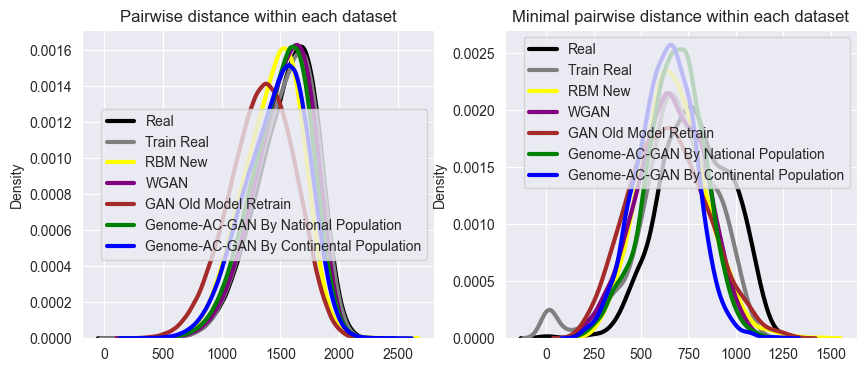

In [45]:
dSS_dic = dict()
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
for cat, mat in datasets.items():
    dAB = distance.cdist(mat, mat, 'cityblock')
    np.fill_diagonal(dAB, np.Inf)
    dSS_dic[cat] = dAB.min(axis=1)
    sns.kdeplot(dAB[np.triu_indices(dAB.shape[0], k=1)], linewidth=3, label=cat)  # dSS
plt.title("Pairwise distance within each dataset")
plt.legend()

plt.subplot(1, 2, 2)
for cat, d in dSS_dic.items():
    sns.kdeplot(dSS_dic[cat], linewidth=3, label=cat)
plt.title("Minimal pairwise distance within each dataset")
plt.legend()

plt.savefig(os.path.join(output_dir, "haplo_pairw_distrib_within.pdf"))

In [46]:
haplo = np.concatenate(list(datasets.values())).T  # orientation of scikit allele

outFilePrefix = ''
# if not ref in model_name_to_input_file.keys(): continue
ref = 'Real'
print("Computing AATS with ref " + ref)
AA, MINDIST = computeAAandDist(
    pd.DataFrame(haplo.T),
    extra_sample_info.label,
    models_to_data.keys(),
    refCateg=ref,
    saveAllDist=True,
    output_dir=output_dir,
    outFilePrefix=outFilePrefix)

# save AA and MINDIST pd.DataFrame to csv
# np.array of all pariwise distances are saved as npz automatically when calling computeAAandDist with saveAllDist=True
AA.to_csv(os.path.join(output_dir, f'AA_{ref}.csv.bz2'), index=None)
MINDIST.to_csv(os.path.join(output_dir, f'MINDIST_{ref}.csv.bz2'), index=None)

Computing AATS with ref Real
Train Real
RBM New
WGAN
GAN Old Model Retrain
Genome-AC-GAN By National Population
Genome-AC-GAN By Continental Population


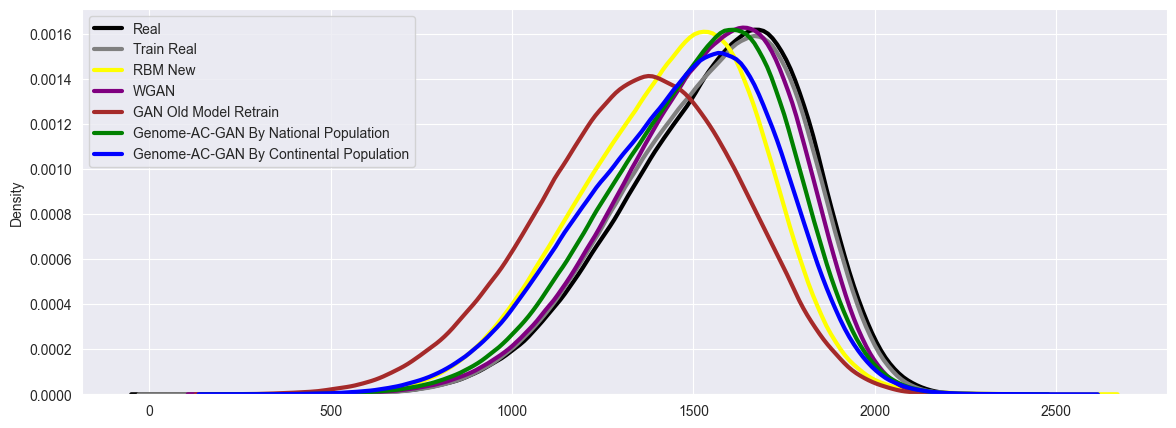

In [47]:
#### Distribution WITHIN model_namesories
W = pd.DataFrame(columns=['stat', 'statistic', 'label', 'comparaison'])

plt.figure(figsize=(14, 5))
# plt.subplot(1, 2, 1)
model_names = models_to_data.keys()
for i, model_name in enumerate(model_names):
    subset = (np.load('{}/dist_{}_{}.npz'.format(output_dir, model_name, model_name)))['dist']
    if model_name == 'Real':
        subsetreal = subset
    sns.kdeplot(subset, linewidth=3, label=model_name)

    sc = scs.wasserstein_distance(subsetreal, subset)
    new_row = pd.DataFrame(
        {'stat': ['wasserstein'], 'statistic': [sc], 'label': [model_name], 'comparaison': ['within']})
    W = pd.concat([W, new_row], ignore_index=True)

plt.legend(loc='upper left')
plt.savefig(os.path.join(output_dir, "distribution_haplotypic_pairwise_diff.jpg"))

/var/folders/gg/cdx7t5lx167_frdvqm0mxt5c0000gn/T/ipykernel_57776/3980683104.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(subset, hist=False, kde=True,
/var/folders/gg/cdx7t5lx167_frdvqm0mxt5c0000gn/T/ipykernel_57776/3980683104.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns

          stat   statistic                                    label   
0  wasserstein    0.000000                                     Real  \
1  wasserstein   10.657606                               Train Real   
2  wasserstein  117.928185                                  RBM New   
3  wasserstein   27.862376                                     WGAN   
4  wasserstein  209.099366                    GAN Old Model Retrain   
5  wasserstein   53.262197     Genome-AC-GAN By National Population   
6  wasserstein   93.549592  Genome-AC-GAN By Continental Population   
0  wasserstein    0.000000                                     Real   
0  wasserstein   10.657606                               Train Real   
0  wasserstein  117.928185                                  RBM New   
0  wasserstein   27.862376                                     WGAN   
0  wasserstein  209.099366                    GAN Old Model Retrain   
0  wasserstein   53.262197     Genome-AC-GAN By National Population   
0  was

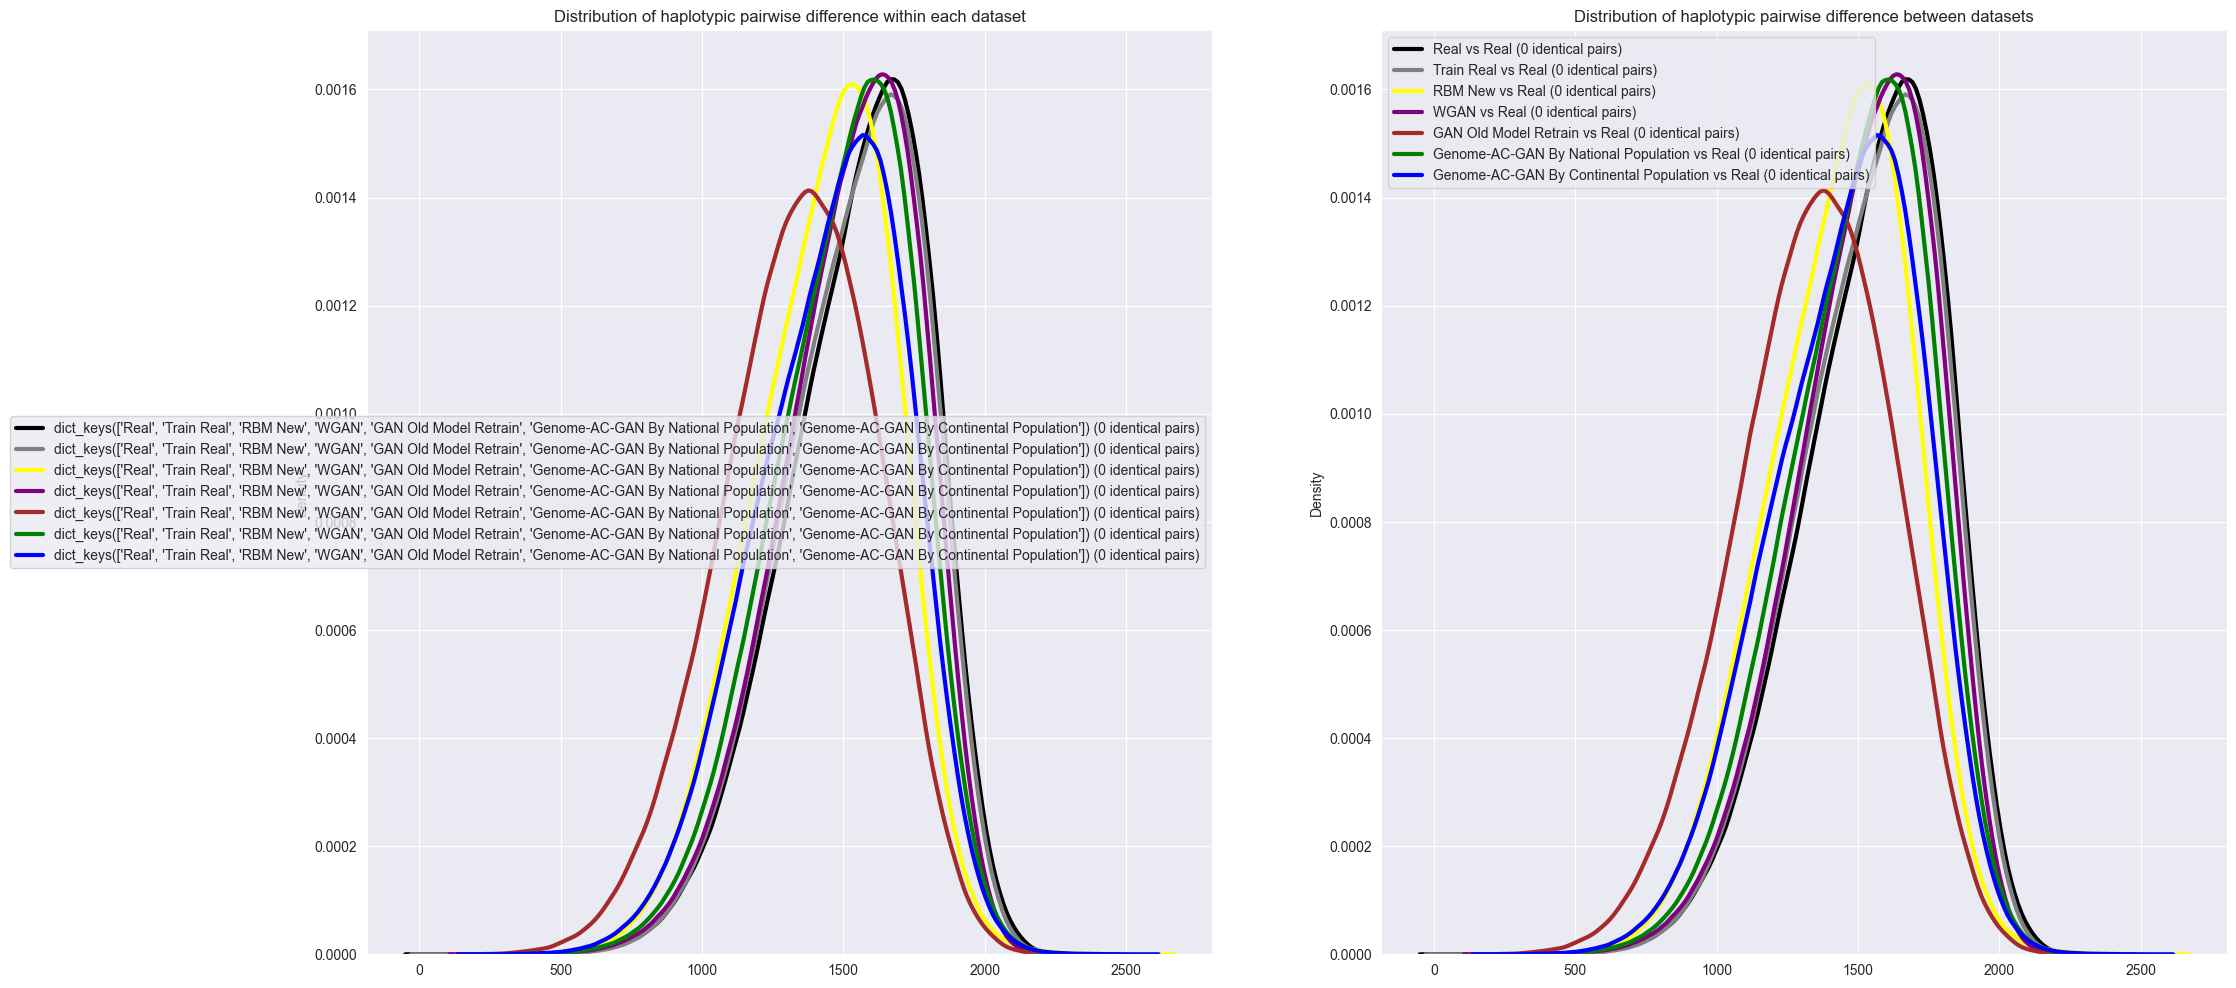

In [48]:
#### Distribution WITHIN model_namesories
W = pd.DataFrame(columns=['stat', 'statistic', 'label', 'comparaison'])

plt.figure(figsize=(24, 12))
plt.subplot(1, 2, 1)
model_names = models_to_data.keys()
for i, model_name in enumerate(model_names):
    subset = (np.load('{}/dist_{}_{}.npz'.format(output_dir, model_name, model_name)))['dist']
    if model_names == 'Real':
        subsetreal = subset
    sns.distplot(subset, hist=False, kde=True,
                 kde_kws={'linewidth': 3},  #'bw':.02
                 label='{} ({} identical pairs)'.format(model_names, (subset == 0).sum()))

    sc = scs.wasserstein_distance(subsetreal, subset)
    W = pd.concat([W, pd.DataFrame(
        [{'stat': 'wasserstein', 'statistic': sc, 'pvalue': None, 'label': model_name, 'comparaison': 'between'}])],
                  ignore_index=True)

plt.title("Distribution of haplotypic pairwise difference within each dataset")
plt.legend()
#plt.savefig(outDir+"haplo_pairw_distrib_within_{}_simplify.pdf".format("-".join(categ)))
subsetreal = None

#### Distribution BETWEEN categories
plt.subplot(1, 2, 2)
model_names = models_to_data.keys()
for i, model_name in enumerate(model_names):
    subset = (np.load('{}/dist_{}_{}.npz'.format(output_dir, model_name, model_name)))['dist']
    if model_name == 'Real':
        subsetreal = subset
    sns.distplot(subset, hist=False, kde=True,
                 kde_kws={'linewidth': 3},  #'bw':.02
                 label='{} vs {} ({} identical pairs)'.format(model_name, 'Real', (subset == 0).sum()))

    sc = scs.wasserstein_distance(subsetreal, subset)
    W = pd.concat([W, pd.DataFrame(
        [{'stat': 'wasserstein', 'statistic': sc, 'pvalue': None, 'label': model_name, 'comparaison': 'between'}])])

plt.title("Distribution of haplotypic pairwise difference between datasets")
plt.legend()
plt.savefig(os.path.join(output_dir, "haplo_pairw_distrib.pdf"))

scores = pd.concat([W])

print(W)

In [49]:
MINDIST.to_csv(os.path.join(output_dir, "MINDIST.csv"))

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_score_distributions(df):
    # Create a figure with three subplots, one for each score type
    fig, axes = plt.subplots(1, 3, figsize=(20, 15))

    # Set the column names for the score types
    score_types = ['dTS', 'dST', 'dSS']

    # Set the colors for each model
    model_colors = sns.color_palette('Set1', n_colors=len(df['cat'].unique()))

    # Create a dictionary to store the model names and their corresponding colors
    model_color_dict = dict(zip(df['cat'].unique(), model_colors))

    # Iterate over the score types
    for i, score_type in enumerate(score_types):
        # Select the data for the current score type
        data = df[['cat', score_type]]

        # Melt the data to transform it into long format
        data_melted = data.explode(score_type).reset_index(drop=True)

        # Plot the distribution for each model
        for model in df['cat'].unique():
            model_data = data_melted[data_melted['cat'] == model]
            color = model_color_dict[model]

            sns.histplot(data=model_data, x=score_type, element='step', stat='density',
                         common_norm=False, fill=False, kde=True,
                         ax=axes[i], color=color, label=model)

        # Set plot title and labels
        axes[i].set_title(f'Distribution of {score_type}')
        axes[i].set_xlabel('Score')
        axes[i].set_ylabel('Density')

        # Set legend
        axes[i].legend(title='Model', loc='upper right')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()


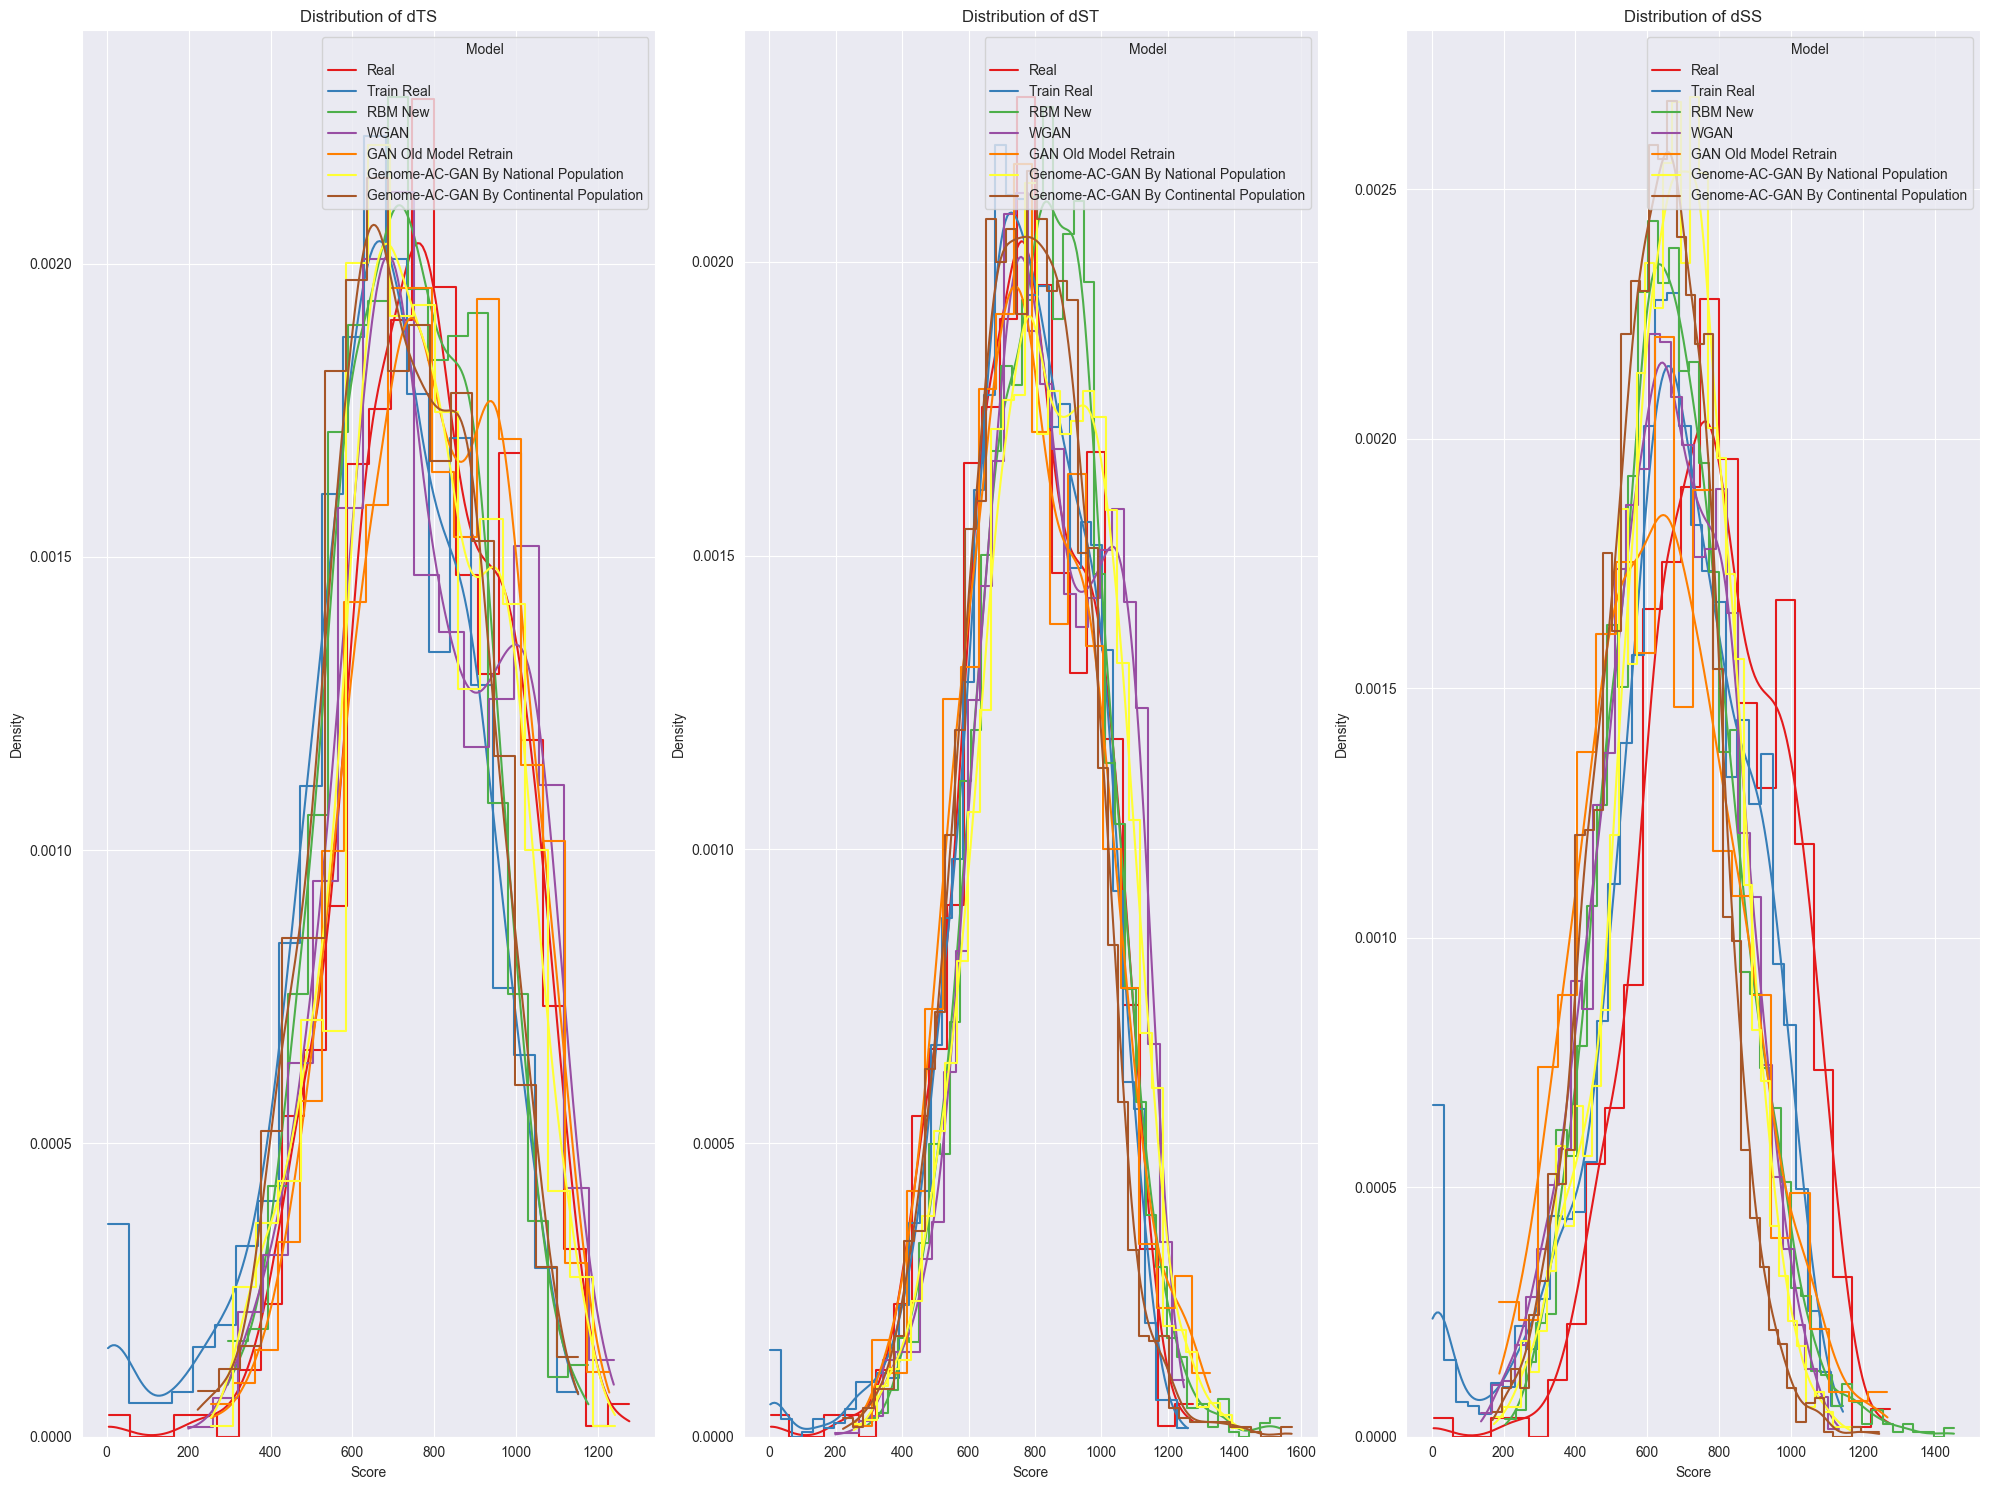

In [51]:
plot_score_distributions(MINDIST)


In [52]:
def plot_score_distributions(df, score_name):
    flattened_df = df[['cat', score_name]].explode(score_name).reset_index(drop=True)

    # Reorder the unique model names with 'Real' at the front
    unique_models = list(flattened_df["cat"].unique())
    unique_models.remove('Real')
    unique_models.append('Real')
    color_palette['Real'] = 'black'
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 8))

    # Iterate over the reordered unique model names and plot the distribution for each
    for model_name in unique_models:
        if model_name == 'Real':
            sns.kdeplot(data=flattened_df[flattened_df["cat"] == model_name], x=score_name, label=model_name,
                        fill=True, common_norm=False, alpha=0.6, color='black')
        else:
            sns.kdeplot(data=flattened_df[flattened_df["cat"] == model_name], x=score_name, label=model_name,
                        common_norm=False, alpha=1, linewidth=5)

    plt.xlabel(score_name)
    plt.ylabel("Density")
    plt.legend(title="Model Name", loc="upper right")
    plt.title(f"Distribution of {score_name} by Model")
    plt.savefig(os.path.join(output_dir, score_name + "_DISTRIBUTIONS.jpg"))
    plt.show()




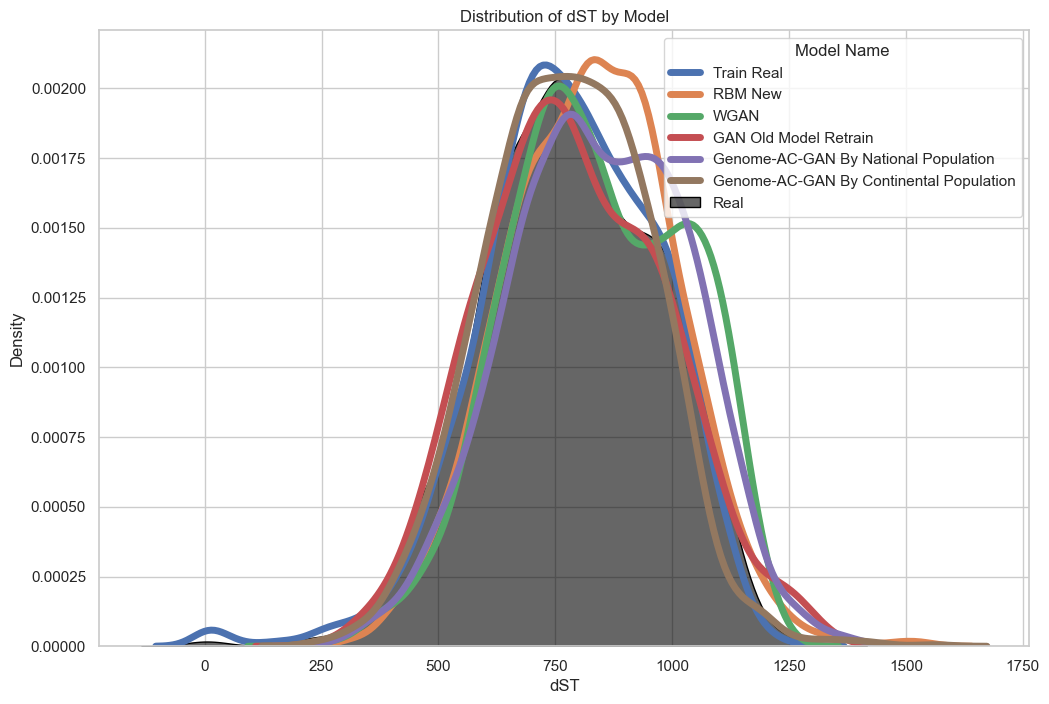

In [53]:
plot_score_distributions(MINDIST, 'dST')

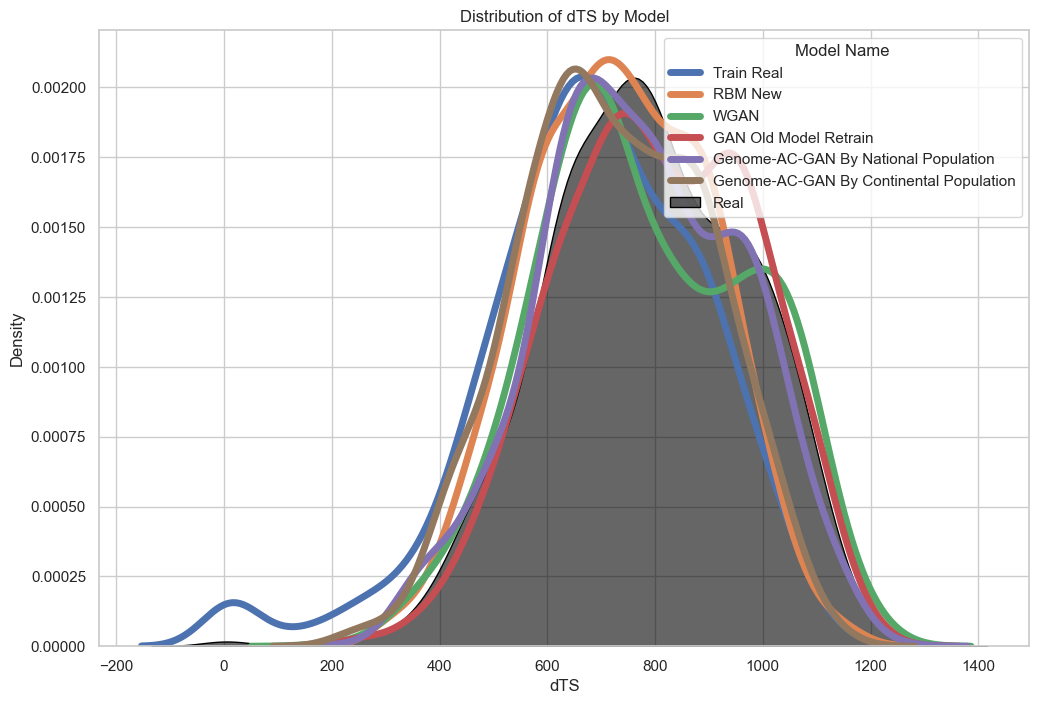

In [54]:
plot_score_distributions(MINDIST, 'dTS')

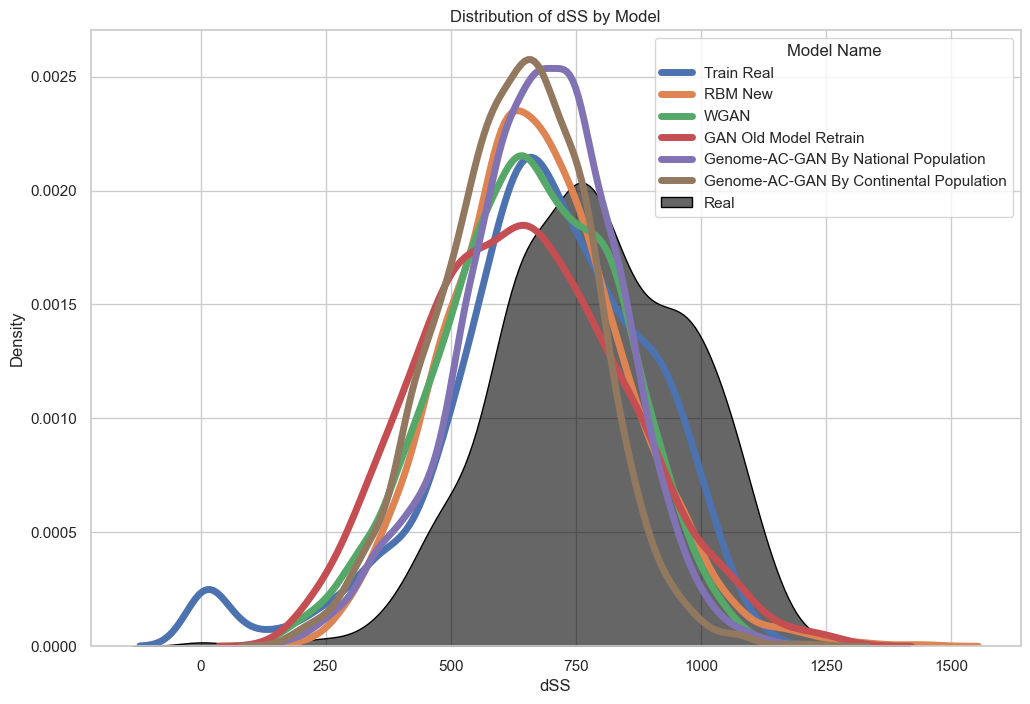

In [55]:
plot_score_distributions(MINDIST, 'dSS')

In [56]:
W = pd.DataFrame(columns=['stat', 'statistic', 'label', 'comparaison'])
for model_name in models_to_data.keys():
    for method in ['dTS', 'dST', 'dSS']:
        real = MINDIST[method][MINDIST.cat == 'Real'][0]
        sc = scs.wasserstein_distance(real, MINDIST[method][MINDIST.cat == model_name].values[0])
        new_row = pd.DataFrame({'stat': ['wasserstein'], 'statistic': [sc],
                                'label': [model_name], 'comparaison': [method]})
        W = pd.concat([W, new_row], ignore_index=True)
scores = pd.concat([W])

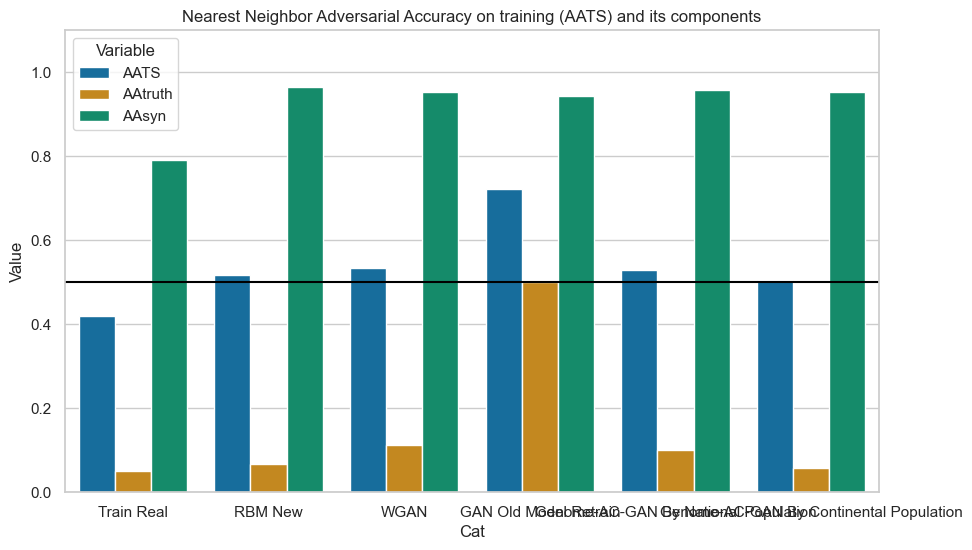

In [57]:
scores = pd.concat([scores, W])
scores.to_csv(os.path.join(output_dir, "scores_pairwise_distances.csv"), index=False)

plt.figure(figsize=(1.5 * len(model_names), 6))

sns.barplot(x='Cat', y='Value', hue='Variable', palette=sns.color_palette('colorblind'),
            data=(AA.drop(columns=['PrivacyLoss', 'ref'], errors='ignore')).melt(id_vars='cat').rename(
                columns=str.title))
plt.axhline(0.5, color='black')
if 'Real_test' in AA.cat.values:
    plt.axhline(np.float(AA[AA.cat == 'Real_test'].AATS), color=sns.color_palette()[0], ls='--')
plt.ylim(0, 1.1)
plt.title("Nearest Neighbor Adversarial Accuracy on training (AATS) and its components")
plt.savefig(os.path.join(output_dir, "AATS_scores.pdf"))

Test = '_Test2'
Train = ''  # means Training set is Real
dfPL = plotPrivacyLoss(Train, Test, output_dir, color_palette, color_palette)

Test = '_Test2'
Train = '_Test1'
dfPL = plotPrivacyLoss(Train, Test, output_dir, color_palette, color_palette)


 gap=1 SNPs Real Train Real RBM New WGAN GAN Old Model Retrain Genome-AC-GAN By National Population Genome-AC-GAN By Continental Population 
 gap=4 SNPs Real Train Real RBM New WGAN GAN Old Model Retrain Genome-AC-GAN By National Population Genome-AC-GAN By Continental Population 
 gap=16 SNPs Real Train Real RBM New WGAN GAN Old Model Retrain Genome-AC-GAN By National Population Genome-AC-GAN By Continental Population 
 gap=64 SNPs Real Train Real RBM New WGAN GAN Old Model Retrain Genome-AC-GAN By National Population Genome-AC-GAN By Continental Population 
 gap=256 SNPs Real Train Real RBM New WGAN GAN Old Model Retrain Genome-AC-GAN By National Population Genome-AC-GAN By Continental Population 
 gap=512 SNPs Real Train Real RBM New WGAN GAN Old Model Retrain Genome-AC-GAN By National Population Genome-AC-GAN By Continental Population 
 gap=1024 SNPs Real Train Real RBM New WGAN GAN Old Model Retrain Genome-AC-GAN By National Population Genome-AC-GAN By Continental Population 
 ga

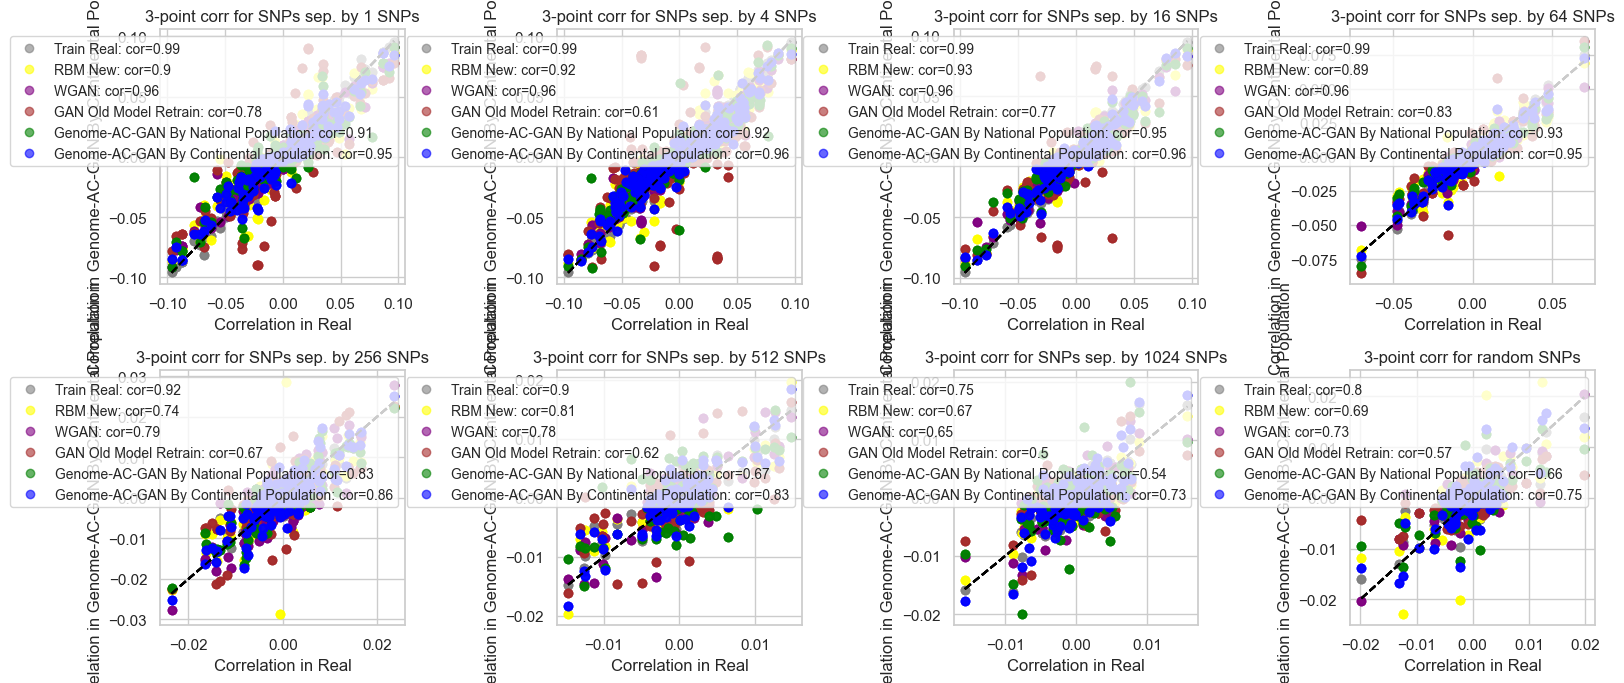

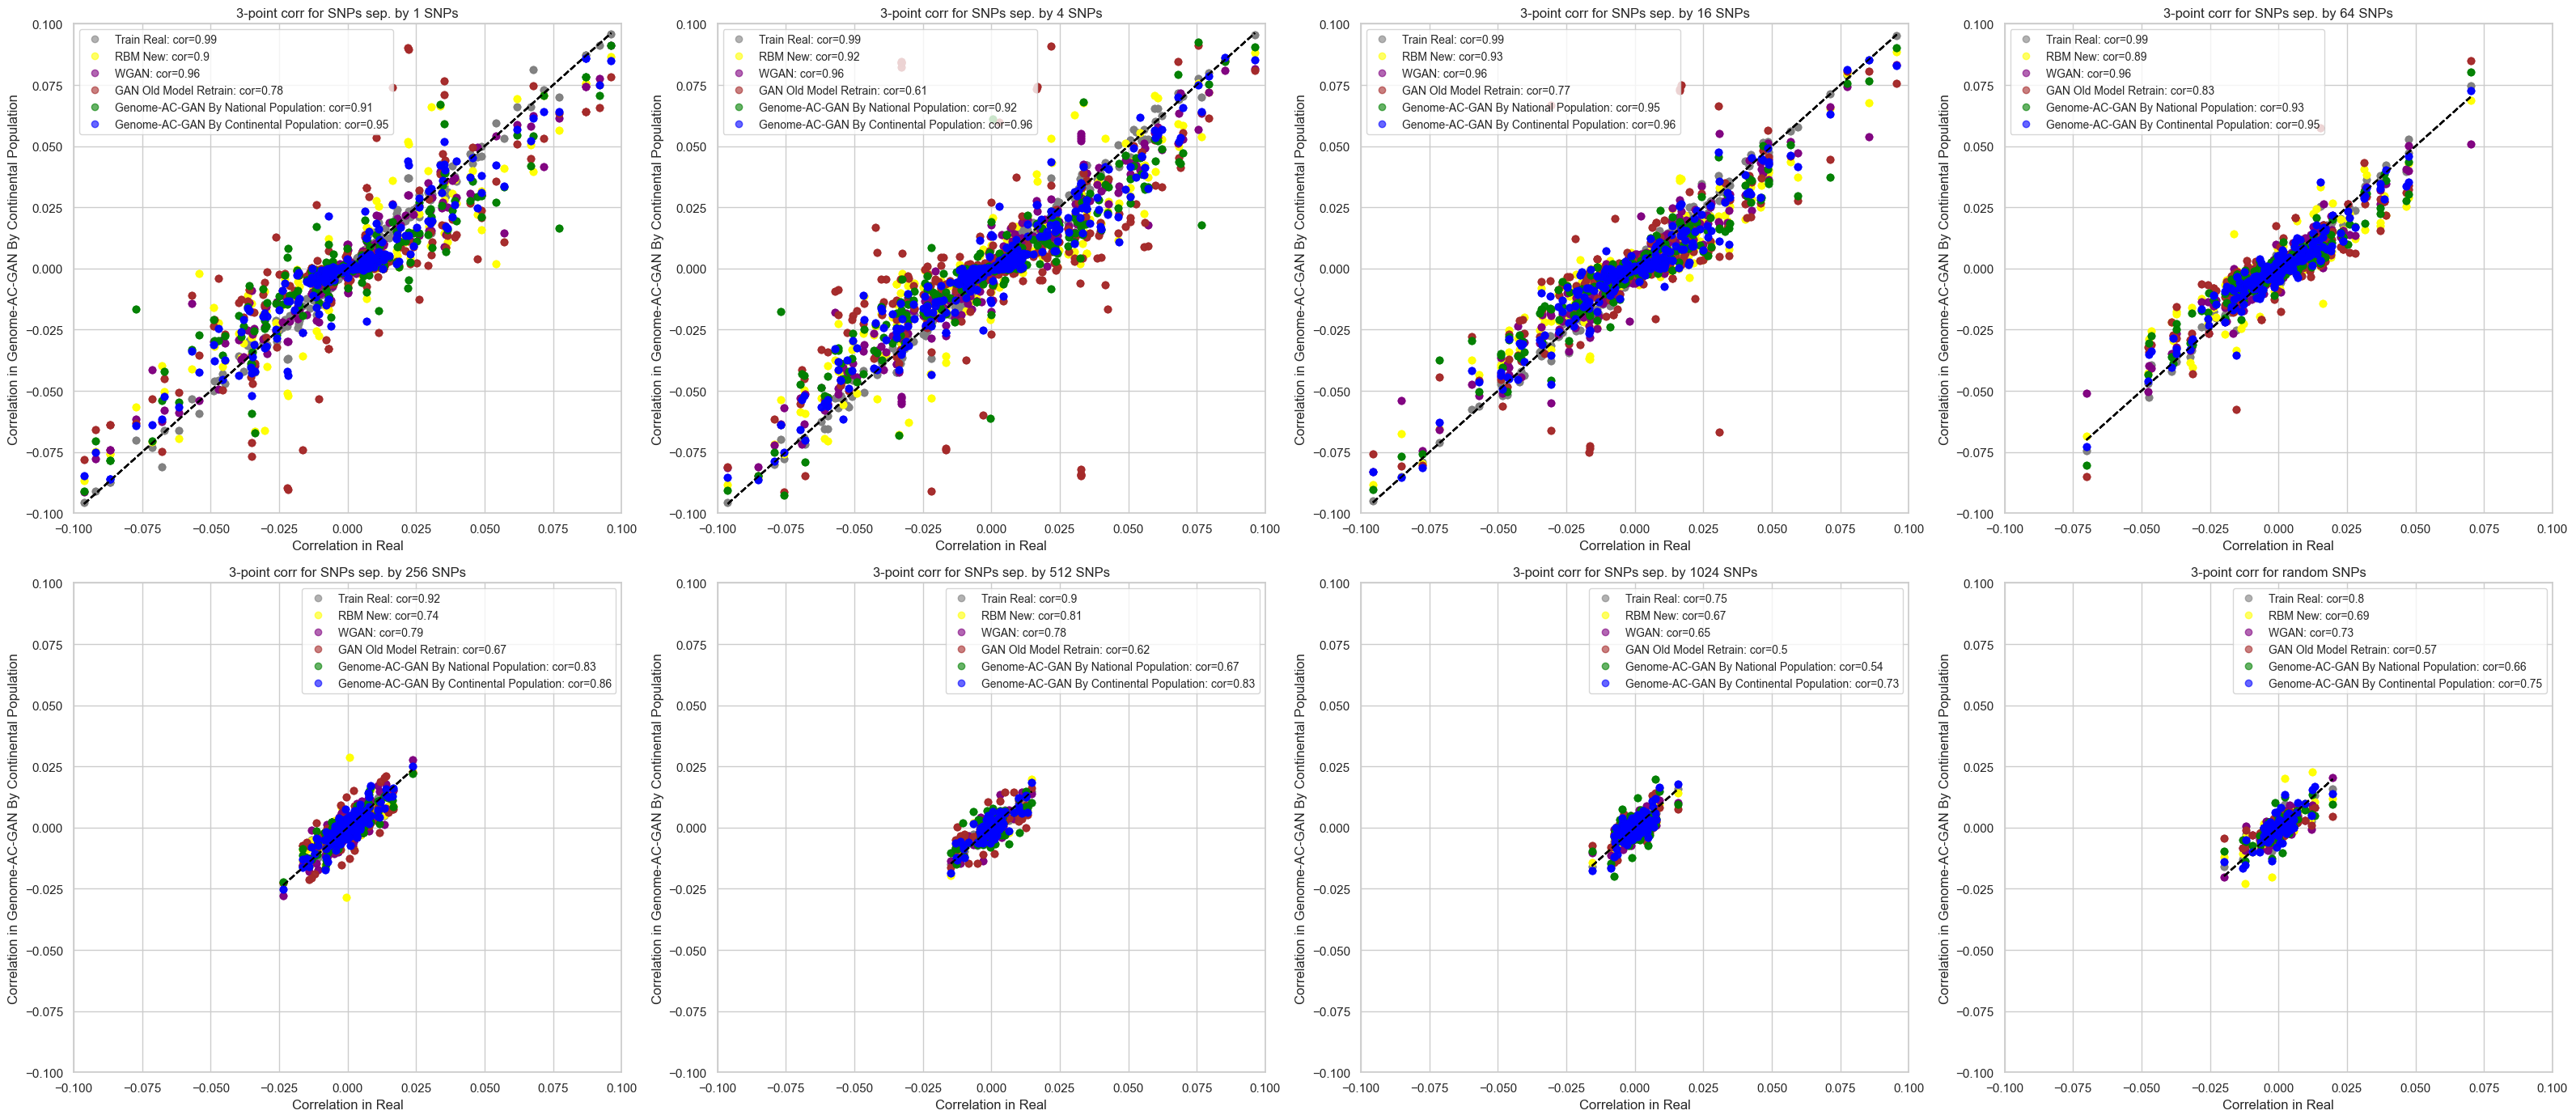

In [58]:
def get_counts(haplosubset, points):
    counts = np.unique(
        np.apply_along_axis(
            lambda x: ''.join(map(str, x[points])),
            # lambda x: ''.join([str(x[p]) for p in points]),
            0, haplosubset),
        return_counts=True)
    return (counts)


def get_frequencies(counts):
    l = len(counts[0][0])  # haplotype length
    nind = np.sum(counts[1])
    f = np.zeros(shape=[2] * l)
    for i, allele in enumerate(counts[0]):
        f[tuple(map(int, allele))] = counts[1][i] / nind
    return f


def three_points_cor(haplosubset, out='all'):
    F = dict()
    for points in [[0], [1], [2], [0, 1], [0, 2], [1, 2], [0, 1, 2]]:
        strpoints = ''.join(map(str, points))
        F[strpoints] = get_frequencies(
            get_counts(haplosubset, points)
        )

    cors = [
        F['012'][a, b, c] - F['01'][a, b] * F['2'][c] - F['12'][b, c] * F['0'][a] - F['02'][a, c] * F['1'][b] + 2 *
        F['0'][a] * F['1'][b] * F['2'][c] for a, b, c in itertools.product(*[[0, 1]] * 3)]
    if out == 'mean':
        return (np.mean(cors))
    if out == 'max':
        return (np.max(np.abs(cors)))
    if out == 'all':
        return (cors)
    return (ValueError(f"out={out} not recognized"))


# def mult_three_point_cor(haplo, extra_sample_info, model_name, picked_three_points):
#    return [three_points_cor(haplo[np.ix_(snps,extra_sample_info.label==model_name)], out='all') for snps in picked_three_points]

# set the seed so that the same real individual are subsampled (when needed)
# to ensure consistency of the scores when adding a new model or a new sumstat
np.random.seed(3)
random.seed(3)

# Compute 3 point correlations results for different datasets and different distances between SNPs

# pick distance between SNPs at which 3point corr will be computed
# (defined in nb of snps)
# a gap of -9 means that snp triplets are chosen completely at random (not predefined distance)
# for each category we randomly pick 'nsamplesets' triplets

# if datasets have different nb of snps, for convenience we will sample
# slightly more at the beginning of the chunk

gap_vec = [1, 4, 16, 64, 256, 512, 1024, -9]
nsamplesets = 1000
min_nsnp = min([dat.shape[1] for dat in datasets.values()])
cors_meta = dict()
for gap in gap_vec:
    print(f'\n gap={gap} SNPs', end=' ')
    if gap < 0:
        # pick 3 random snps
        picked_three_points = [random.sample(range(min_nsnp), 3) for _ in range(nsamplesets)]
    else:
        try:
            # pick 3 successive snps spearated by 'gap' SNPs
            step = gap + 1
            picked_three_points = [np.asarray(random.sample(range(min_nsnp - 2 * step), 1)) + [0, step, 2 * step]
                                   for _
                                   in range(nsamplesets)]
        except:
            continue  # if there were not enough SNPs for this gap
    cors = dict()

    for model_name in datasets.keys():
        print(model_name, end=' ')
        # cors[model_name]=[three_points_cor(haplo[np.ix_(snps,extra_sample_info.label==model_name)], out='all') for snps in picked_three_points]
        cors[model_name] = [three_points_cor(datasets[model_name][:, snps].T, out='all') for snps in
                            picked_three_points]

    cors_meta[gap] = cors.copy()

# print(cors_meta)

with open(os.path.join(output_dir, "3pointcorr.pkl"), "wb") as outfile:
    pickle.dump(cors_meta, outfile)

# Plot 3-point correlations results

plt.figure(figsize=(2 * len(cors_meta), 7))
# plt.figure(figsize=(figwi,figwi/2))
for i, gap in enumerate((cors_meta).keys()):
    ax = plt.subplot(2, int(np.ceil(len(cors_meta) / 2)), int(i) + 1)
    cors = cors_meta[gap]
    real = list(np.array(cors['Real']).flat)
    lims = [np.min(real), np.max(real)]
    for key, val in cors.items():
        if key == 'Real': continue
        val = list(np.array(val).flat)
        plotreg(x=real, y=val, keys=['Real', key],
                statname='Correlation', col=color_palette[key], ax=ax)
    if gap < 0:
        plt.title('3-point corr for random SNPs')
    else:
        plt.title(f'3-point corr for SNPs sep. by {gap} SNPs')

    plt.legend(fontsize='small')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '3point_correlations.jpg'), dpi=300)  # can pick one of the format

# Same plot with axes limit fixed to (-0.1,0.1) for the sake of comparison

plt.figure(figsize=(4 * len(cors_meta), 14))
# plt.figure(figsize=(figwi,figwi/2))
for i, gap in enumerate((cors_meta).keys()):
    ax = plt.subplot(2, int(np.ceil(len(cors_meta) / 2)), int(i) + 1)
    cors = cors_meta[gap]
    real = list(np.array(cors['Real']).flat)
    lims = [np.min(real), np.max(real)]
    for key, val in cors.items():
        if key == 'Real': continue
        val = list(np.array(val).flat)
        plotreg(x=real, y=val, keys=['Real', key],
                statname='Correlation', col=color_palette[key], ax=ax)
        ax.set_xlim((-.1, .1))
        ax.set_ylim((-.1, .1))

    if gap < 0:
        plt.title('3-point corr for random SNPs')
    else:
        plt.title(f'3-point corr for SNPs sep. by {gap} SNPs')

    plt.legend(fontsize='small')
plt.tight_layout()

plt.savefig(os.path.join(output_dir, '3point_correlations_fixlim.pdf'), dpi=300)